<a href="https://colab.research.google.com/github/raphaelchaves/papa-linguas/blob/main/Projeto_PLN_ICMC_V3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://4.bp.blogspot.com/-tbAWK7KCPq0/TbVg-SmjNFI/AAAAAAAAAtQ/QboG2_SDuNo/s1600/logo+fiinal.jpg" width="300">

#Análise de Sentimentos

Projeto sobre análise de sentimentos desenvolvido como parte da disciplina de Processamento em Língua Natural. ICMC-USP

## Principais Etapas:
* **Coleta de Dados**
* **Pré-processamento de Dados**
* **Nuvem de Palavras**
* **Remoção de Stop Words**
* **Tokenização**
* **Análise Exploratória dos Dados**
* **Lematização**
* **Variável Dependente**
* **Análise de Desbalanceamento**
* **Processo de Vetorização (WordVec)**
* **Divisão dos dados - Treino e Teste**
* **Balanceamento de Classes**
* **Modelos de Aprendizado de Máquina (Supervisionados)**
* **Modelo Simbólico**
* **Modelo de Aprendizado Profundo**

In [ ]:
# Instalação das bibliotecas necessárias (descomente se não tiver instalado)
#!pip install transformers pandas scikit-learn torch torchvision torchaudio gensim spacy wordcloud nltk seaborn
#!pip install --force-reinstall scipy gensim spacy nltk
#!pip install --force-reinstall emoji


In [1]:
# Manipulação de dados
import pandas as pd
import numpy as np
from collections import Counter

# Visualização
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML
from wordcloud import WordCloud

# Pré-processamento de texto
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import RSLPStemmer
import emoji
import spacy
import gensim
from gensim.models import Word2Vec

# Modelagem e aprendizado de máquina
from sklearn.model_selection import train_test_split
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    EarlyStoppingCallback
)
import torch
from scipy.special import softmax  # Para converter logits em probabilidades

# Outros
import requests
import io
import warnings
warnings.filterwarnings('ignore')

# Coleta de Dados

In [2]:
# URL do Córpus Escolhido
url = "https://raw.githubusercontent.com/americanas-tech/b2w-reviews01/main/B2W-Reviews01.csv"

# Lendo o arquivo csv num pandas dataframe
try:
    original_data = pd.read_csv(url)
    print("DataFrame importado com sucesso!")
except Exception as e:
    print(f"Erro identificado: {e}")

DataFrame importado com sucesso!


In [3]:
# Armazena dataset original no Google Drive
# Passo 1: Monta conexão com Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Passo 2: Define o caminho onde o dataframe será salvo no Google Drive
save_path = '/content/drive/My Drive/ICMC/PLN/original_data.pkl'

# Passo 3: Salva o dataframe utilizando pickle
original_data.to_pickle(save_path)
print(f"DataFrame exportado com sucesso para {save_path}")

DataFrame exportado com sucesso para /content/drive/My Drive/ICMC/PLN/original_data.pkl


In [5]:
# Exibe o conteúdo do dataframe em formato de uma tabela HTML
display(HTML(original_data.to_html(max_rows=5)))

,submission_date,reviewer_id,product_id,product_name,product_brand,site_category_lv1,site_category_lv2,review_title,overall_rating,recommend_to_a_friend,review_text,reviewer_birth_year,reviewer_gender,reviewer_state
0,2018-01-01 00:11:28,d0fb1ca69422530334178f5c8624aa7a99da47907c44de0243719b15d50623ce,132532965,"Notebook Asus Vivobook Max X541NA-GO472T Intel Celeron Quad Core 4GB 500GB Tela LED 15,6"" Windows - 10 Branco",NaN,Informática,Notebook,Bom,4,Yes,Estou contente com a compra entrega rápida o único problema com as Americanas é se houver troca ou devolução do produto o consumidor tem problemas com espera.,1958.0,F,RJ
1,2018-01-01 00:13:48,014d6dc5a10aed1ff1e6f349fb2b059a2d3de511c7538a9008da562ead5f5ecd,22562178,Copo Acrílico Com Canudo 500ml Rocie,NaN,Utilidades Domésticas,"Copos, Taças e Canecas","Preço imbatível, ótima qualidade",4,Yes,"Por apenas R$1994.20,eu consegui comprar esse lindo copo de acrílico.",1996.0,M,SC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132371,2018-05-31 23:46:48,e6fb0b19277d01c2a300c7837a105f3c369377e92f9c19ed7b03889ad1ce5509,6774907,Etiquetas Jurídicas Vade Mecum - Marca Fácil,marca facil,Papelaria,Material de Escritório,O produto não é bom.,1,No,"Material fraco, poderia ser melhor. Ficou devendo na minha opinião.",1991.0,M,RJ
132372,2018-05-31 23:50:33,ea9467aa73271fb4f68c04f4dd4f4eef304d6ee85441fbcd82cda63e620954c3,114081902,Painel de Fotos Bee Colection Rue Bac (74x94x3cm) Preto para 28 Fotos - Kapos,kapos,Decoração,Painel de Fotos,Produto não entregue,1,No,"Comprei esse produto, quando chegou estava com avaria. Devolvi, já vai fazer 3 meses, não me enviaram o produto e nem o estorno.",1982.0,F,ES


### Pré-Processamento dos Dados

In [6]:
# Cria um novo dataframe chamado "development_sample" contendo apenas os atributos relevantes para a análise de sentimentos
development_sample = original_data[['review_text', 'overall_rating', 'recommend_to_a_friend', 'site_category_lv1', 'site_category_lv2','review_title', 'reviewer_state', 'reviewer_gender']]

In [7]:
# O atributo "review title", introduz ou sumariza a revisão do cliente, enquanto que o atributo "review_text" contempla
# todo o comentário do cliente sobre um determinado produto, seja ele positivo ou negativo.
# Considerando que ambos os atributos expressam uma opinião do cliente, estamos criando um novo campo chamado
# "customer_review_text", o qual contempla as opiniões expressas nestes 2 campos.
development_sample['customer_review_text'] = development_sample['review_title'] + ' ' + development_sample['review_text']
development_sample.head(10)

,review_text,overall_rating,recommend_to_a_friend,site_category_lv1,site_category_lv2,review_title,reviewer_state,reviewer_gender,customer_review_text
0,Estou contente com a compra entrega rápida o ú...,4,Yes,Informática,Notebook,Bom,RJ,F,Bom Estou contente com a compra entrega rápida...
1,"Por apenas R$1994.20,eu consegui comprar esse ...",4,Yes,Utilidades Domésticas,"Copos, Taças e Canecas","Preço imbatível, ótima qualidade",SC,M,"Preço imbatível, ótima qualidade Por apenas R$..."
2,SUPERA EM AGILIDADE E PRATICIDADE OUTRAS PANEL...,4,Yes,Eletroportáteis,Panela Elétrica,ATENDE TODAS AS EXPECTATIVA.,SP,M,ATENDE TODAS AS EXPECTATIVA. SUPERA EM AGILIDA...
3,MEU FILHO AMOU! PARECE DE VERDADE COM TANTOS D...,4,Yes,Brinquedos,Veículos de Brinquedo,presente mais que desejado,SP,F,presente mais que desejado MEU FILHO AMOU! PAR...
4,"A entrega foi no prazo, as americanas estão de...",5,Yes,TV e Home Theater,TV,"Sem duvidas, excelente",MG,M,"Sem duvidas, excelente A entrega foi no prazo,..."
5,"Excelente produto, por fora em material acríli...",5,Yes,Utilidades Domésticas,"Copos, Taças e Canecas",Produto imperdível,PA,M,"Produto imperdível Excelente produto, por fora..."
6,"produto mto bom, com essa garrafinha vc pode a...",5,Yes,Utilidades Domésticas,"Copos, Taças e Canecas",ótimo,NaN,NaN,"ótimo produto mto bom, com essa garrafinha vc ..."
7,Produto excelente qualidade boa câmera desenvo...,4,Yes,Celulares e Smartphones,Smartphone,Gostei bastante do produto,GO,M,Gostei bastante do produto Produto excelente q...
8,O barulho e minimo e o vento é bem forte na ve...,5,Yes,Casa e Construção,Climatização,Gostei do produto,SP,M,Gostei do produto O barulho e minimo e o vento...
9,MEU PRODUTO NAO FOI ENTREGUE E A AMERICANAS ES...,1,No,Casa e Construção,Iluminação,NÃO RECEBI O PRODUTO,RJ,M,NÃO RECEBI O PRODUTO MEU PRODUTO NAO FOI ENTRE...


In [8]:
# Remove valores NaN
development_sample.dropna(inplace = True)

In [9]:
# Remove Dados Duplicados
development_sample.drop_duplicates(keep='first', inplace=True)

In [10]:
# Cria um novo atributo na qual o texto será convertido apenas para letras minúsculas
development_sample['review_text_preprocessed'] = development_sample['customer_review_text'].apply(lambda x: " ".join(x.lower() for x in x.split()))

In [11]:
# Remover pontuação e adicionar espaço usando expressões regulares (Noise)
development_sample['review_text_preprocessed'] = development_sample['review_text_preprocessed'].str.replace(r'[^\w\s]', ' ', regex=True)

In [12]:
# Remove números
development_sample['review_text_preprocessed'] = development_sample['review_text_preprocessed'].str.replace('\d+', ' ', regex=True)

In [13]:
# O atributo rating representa a revisão dos clientes que se baseia no seguinte mapeamento:
mapping = {1: 'Ruim', 2: 'Regular', 3: 'Bom', 4: 'Ótimo', 5: 'Excelente'}

development_sample['customer_review_rating'] = development_sample['overall_rating'].map(mapping)

display(HTML(development_sample.to_html(max_rows=5)))

,review_text,overall_rating,recommend_to_a_friend,site_category_lv1,site_category_lv2,review_title,reviewer_state,reviewer_gender,customer_review_text,review_text_preprocessed,customer_review_rating
0,Estou contente com a compra entrega rápida o único problema com as Americanas é se houver troca ou devolução do produto o consumidor tem problemas com espera.,4,Yes,Informática,Notebook,Bom,RJ,F,Bom Estou contente com a compra entrega rápida o único problema com as Americanas é se houver troca ou devolução do produto o consumidor tem problemas com espera.,bom estou contente com a compra entrega rápida o único problema com as americanas é se houver troca ou devolução do produto o consumidor tem problemas com espera,Ótimo
1,"Por apenas R$1994.20,eu consegui comprar esse lindo copo de acrílico.",4,Yes,Utilidades Domésticas,"Copos, Taças e Canecas","Preço imbatível, ótima qualidade",SC,M,"Preço imbatível, ótima qualidade Por apenas R$1994.20,eu consegui comprar esse lindo copo de acrílico.",preço imbatível ótima qualidade por apenas r eu consegui comprar esse lindo copo de acrílico,Ótimo
...,...,...,...,...,...,...,...,...,...,...,...
132371,"Material fraco, poderia ser melhor. Ficou devendo na minha opinião.",1,No,Papelaria,Material de Escritório,O produto não é bom.,RJ,M,"O produto não é bom. Material fraco, poderia ser melhor. Ficou devendo na minha opinião.",o produto não é bom material fraco poderia ser melhor ficou devendo na minha opinião,Ruim
132372,"Comprei esse produto, quando chegou estava com avaria. Devolvi, já vai fazer 3 meses, não me enviaram o produto e nem o estorno.",1,No,Decoração,Painel de Fotos,Produto não entregue,ES,F,"Produto não entregue Comprei esse produto, quando chegou estava com avaria. Devolvi, já vai fazer 3 meses, não me enviaram o produto e nem o estorno.",produto não entregue comprei esse produto quando chegou estava com avaria devolvi já vai fazer meses não me enviaram o produto e nem o estorno,Ruim


### Nuvem de Palavras

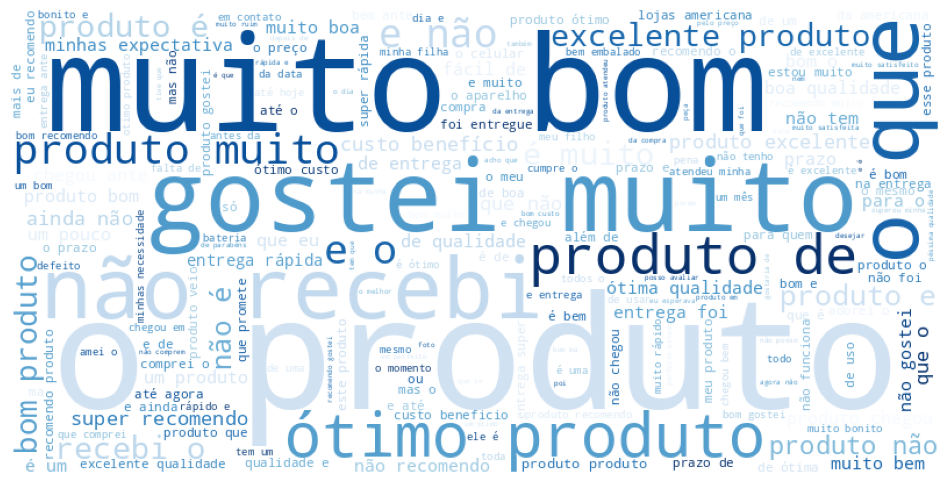

In [14]:
# Neste momento, não aplicamos a "Lematização", dado que a Nuvem de Palavras não
# deve mostrar palavras cortadas ou reduzidas, sob o risco de perder seu sentido.
# Portanto, aplicamos somente o pré-processamento e limpeza inicial dos dados.
# A remoção de stopwords será feita em seguida.

# Combina todos os comentários numa string única
text = ' '.join(development_sample['review_text_preprocessed'])

# Cria a Nuvem de Palavras
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='Blues_r').generate(text)

# Plotando a Nuvem de Palavras
plt.figure(figsize=(12, 12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

### Remoção de Stop Words

**Objetivo:**
Na análise de sentimentos, a etapa de remoção de stop words é uma etapa fundamental do pré-processamento de texto. Stop words são palavras que, em geral, não agregam significado relevante ao contexto do texto quando analisado em um modelo de análise de sentimentos ou outras tarefas de Processamento de Linguagem Natural (PLN).

**1) O que são stop words?**

Stop words são palavras muito comuns que geralmente são removidas durante o pré-processamento de texto. Estas palavras são necessárias para a estrutura gramatical das frases, mas não carregam informações significativas em termos de análise de sentimentos ou outras tarefas de NLP. Em português, algumas dessas palavras incluem:
*   Pronomes: eu, você, ele, ela, nós, eles, etc.
*   Artigos: o, a, os, as, um, uma, uns, umas.
*   Preposições: de, em, para, com, por, sobre, etc.
*   Conjunções: e, mas, ou, porque, que, etc.
*   Outras palavras comuns: muito, pouco, tudo, algo, etc.


Por exemplo:

Frase: "Eu gosto muito de chocolate."

Sem stop words: "gosto chocolate."

Nesse caso, palavras como "Eu", "muito", "de" não ajudam diretamente a identificar o sentimento (positivo ou negativo) da frase. O que é mais importante para identificar o sentimento aqui é "gosto" e "chocolate".


In [15]:
# Efetua download de stopwords da  biblioteca nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [16]:
# Obter todas as stop_words em português, criando uma lista personalizada
stop_words = set(stopwords.words('portuguese'))

In [17]:
nltk.download('punkt_tab')

# Cria uma lista de tokens temporários'
development_sample['tokens_list_tmp'] = development_sample['review_text_preprocessed'].apply(lambda x: word_tokenize(x.lower()))

# Apresenta os 5 casos como exemplo
display(HTML(development_sample.to_html(max_rows=5)))

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


,review_text,overall_rating,recommend_to_a_friend,site_category_lv1,site_category_lv2,review_title,reviewer_state,reviewer_gender,customer_review_text,review_text_preprocessed,customer_review_rating,tokens_list_tmp
0,Estou contente com a compra entrega rápida o único problema com as Americanas é se houver troca ou devolução do produto o consumidor tem problemas com espera.,4,Yes,Informática,Notebook,Bom,RJ,F,Bom Estou contente com a compra entrega rápida o único problema com as Americanas é se houver troca ou devolução do produto o consumidor tem problemas com espera.,bom estou contente com a compra entrega rápida o único problema com as americanas é se houver troca ou devolução do produto o consumidor tem problemas com espera,Ótimo,"[bom, estou, contente, com, a, compra, entrega, rápida, o, único, problema, com, as, americanas, é, se, houver, troca, ou, devolução, do, produto, o, consumidor, tem, problemas, com, espera]"
1,"Por apenas R$1994.20,eu consegui comprar esse lindo copo de acrílico.",4,Yes,Utilidades Domésticas,"Copos, Taças e Canecas","Preço imbatível, ótima qualidade",SC,M,"Preço imbatível, ótima qualidade Por apenas R$1994.20,eu consegui comprar esse lindo copo de acrílico.",preço imbatível ótima qualidade por apenas r eu consegui comprar esse lindo copo de acrílico,Ótimo,"[preço, imbatível, ótima, qualidade, por, apenas, r, eu, consegui, comprar, esse, lindo, copo, de, acrílico]"
...,...,...,...,...,...,...,...,...,...,...,...,...
132371,"Material fraco, poderia ser melhor. Ficou devendo na minha opinião.",1,No,Papelaria,Material de Escritório,O produto não é bom.,RJ,M,"O produto não é bom. Material fraco, poderia ser melhor. Ficou devendo na minha opinião.",o produto não é bom material fraco poderia ser melhor ficou devendo na minha opinião,Ruim,"[o, produto, não, é, bom, material, fraco, poderia, ser, melhor, ficou, devendo, na, minha, opinião]"
132372,"Comprei esse produto, quando chegou estava com avaria. Devolvi, já vai fazer 3 meses, não me enviaram o produto e nem o estorno.",1,No,Decoração,Painel de Fotos,Produto não entregue,ES,F,"Produto não entregue Comprei esse produto, quando chegou estava com avaria. Devolvi, já vai fazer 3 meses, não me enviaram o produto e nem o estorno.",produto não entregue comprei esse produto quando chegou estava com avaria devolvi já vai fazer meses não me enviaram o produto e nem o estorno,Ruim,"[produto, não, entregue, comprei, esse, produto, quando, chegou, estava, com, avaria, devolvi, já, vai, fazer, meses, não, me, enviaram, o, produto, e, nem, o, estorno]"


In [18]:
# Criar lista com todas as palavras consideradas stop words
stop_words_nos_textos = [palavra for tokens in development_sample['tokens_list_tmp'] for palavra in tokens if palavra in stop_words]

In [19]:
# Remover duplicatas e organizar o resultado
stop_words_nos_textos_unicas = sorted(set(stop_words_nos_textos))

In [20]:
# Cria um dataframe contendo todas as stop words identificadas no corpus de treinamento
df_stop_words = pd.DataFrame(stop_words_nos_textos_unicas, columns = ["stop_word_list"])

# Ao todo, 177 stop words foram identificadas no corpus de treinamento
display(HTML(df_stop_words.to_html()))

,stop_word_list
0,a
1,ao
2,aos
3,aquela
4,aquelas
5,aquele
6,aqueles
7,aquilo
8,as
9,até


In [21]:
# Considerando a lista de stop words acima, mantemos "não", "nem", "só", "mas" e "muito"
# porque são importantes para entender a intensidade ou negação nas opiniões dos consumidores.

# removendo as palavras da lista de stop words
stop_words.discard("não")
stop_words.discard("nem")
stop_words.discard("só")
stop_words.discard("mas")
stop_words.discard("muito")

In [22]:
# Atualiza o atributo review_text_preprocessed removendo as stop words,
# com exceção das palavras "não", "nem", "só", "mas" e "muito"

# Remover stopwords
development_sample['review_text_preprocessed'] = development_sample['review_text_preprocessed'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

# Mostra algumas observações como exemplo
display(HTML(development_sample.to_html(max_rows=5)))

,review_text,overall_rating,recommend_to_a_friend,site_category_lv1,site_category_lv2,review_title,reviewer_state,reviewer_gender,customer_review_text,review_text_preprocessed,customer_review_rating,tokens_list_tmp
0,Estou contente com a compra entrega rápida o único problema com as Americanas é se houver troca ou devolução do produto o consumidor tem problemas com espera.,4,Yes,Informática,Notebook,Bom,RJ,F,Bom Estou contente com a compra entrega rápida o único problema com as Americanas é se houver troca ou devolução do produto o consumidor tem problemas com espera.,bom contente compra entrega rápida único problema americanas troca devolução produto consumidor problemas espera,Ótimo,"[bom, estou, contente, com, a, compra, entrega, rápida, o, único, problema, com, as, americanas, é, se, houver, troca, ou, devolução, do, produto, o, consumidor, tem, problemas, com, espera]"
1,"Por apenas R$1994.20,eu consegui comprar esse lindo copo de acrílico.",4,Yes,Utilidades Domésticas,"Copos, Taças e Canecas","Preço imbatível, ótima qualidade",SC,M,"Preço imbatível, ótima qualidade Por apenas R$1994.20,eu consegui comprar esse lindo copo de acrílico.",preço imbatível ótima qualidade apenas r consegui comprar lindo copo acrílico,Ótimo,"[preço, imbatível, ótima, qualidade, por, apenas, r, eu, consegui, comprar, esse, lindo, copo, de, acrílico]"
...,...,...,...,...,...,...,...,...,...,...,...,...
132371,"Material fraco, poderia ser melhor. Ficou devendo na minha opinião.",1,No,Papelaria,Material de Escritório,O produto não é bom.,RJ,M,"O produto não é bom. Material fraco, poderia ser melhor. Ficou devendo na minha opinião.",produto não bom material fraco poderia melhor ficou devendo opinião,Ruim,"[o, produto, não, é, bom, material, fraco, poderia, ser, melhor, ficou, devendo, na, minha, opinião]"
132372,"Comprei esse produto, quando chegou estava com avaria. Devolvi, já vai fazer 3 meses, não me enviaram o produto e nem o estorno.",1,No,Decoração,Painel de Fotos,Produto não entregue,ES,F,"Produto não entregue Comprei esse produto, quando chegou estava com avaria. Devolvi, já vai fazer 3 meses, não me enviaram o produto e nem o estorno.",produto não entregue comprei produto chegou avaria devolvi vai fazer meses não enviaram produto nem estorno,Ruim,"[produto, não, entregue, comprei, esse, produto, quando, chegou, estava, com, avaria, devolvi, já, vai, fazer, meses, não, me, enviaram, o, produto, e, nem, o, estorno]"


### Processo de Tokenização

**Objetivo**

Tokenização é o processo de dividir um texto em unidades menores, chamadas de "tokens". Esses tokens podem ser palavras, frases ou até mesmo caracteres, dependendo do nível de tokenização que você deseja aplicar. No seu caso, você está utilizando a função word_tokenize da biblioteca NLTK para dividir o texto em palavras individuais.

**Benefícios da Tokenização**

* **Estruturação dos Dados:** A tokenização transforma texto não estruturado (como avaliações escritas) em uma estrutura mais manejável. Isso facilita a análise, permitindo que você trabalhe com palavras individuais em vez de longas cadeias de texto.

* **Facilita a Análise:** Com os tokens, você pode realizar várias operações de análise, como contagem de palavras, identificação de palavras-chave e análise de frequência. Isso é fundamental para tarefas como a análise de sentimentos.

* **Preparação para Processamento Adicional:** A tokenização é frequentemente uma etapa preliminar para outras técnicas de processamento de linguagem natural (NLP), como remoção de stop words, stemming, lemmatização e vetorização.

* **Aprimoramento de Modelos de Machine Learning:** Muitos algoritmos de aprendizado de máquina e técnicas de aprendizado profundo requerem os dados em formato tokenizado. A tokenização prepara os dados para serem alimentados em modelos que aprendem a partir de sequências de palavras.

* **Minimização de Ruídos:** Ao trabalhar com tokens, você pode aplicar filtragens em palavras irrelevantes ou pouco informativas (como stop words) mais facilmente.

**Importância da Etapa**
Essa etapa é crucial porque a forma como você representa os dados de texto pode impactar significativamente a eficácia do seu modelo de análise de sentimentos. A tokenização permite que você manipule e analise o texto de maneira mais granular, o que é fundamental para extrair informações significativas e relevantes.

In [23]:
# Tokenizar o texto na coluna 'review_text_processed'
development_sample['review_text_tokenized'] = development_sample['review_text_preprocessed'].apply(lambda x: word_tokenize(x.lower()))

# Apresenta os 5 casos como exemplo
display(HTML(development_sample.to_html(max_rows=5)))

,review_text,overall_rating,recommend_to_a_friend,site_category_lv1,site_category_lv2,review_title,reviewer_state,reviewer_gender,customer_review_text,review_text_preprocessed,customer_review_rating,tokens_list_tmp,review_text_tokenized
0,Estou contente com a compra entrega rápida o único problema com as Americanas é se houver troca ou devolução do produto o consumidor tem problemas com espera.,4,Yes,Informática,Notebook,Bom,RJ,F,Bom Estou contente com a compra entrega rápida o único problema com as Americanas é se houver troca ou devolução do produto o consumidor tem problemas com espera.,bom contente compra entrega rápida único problema americanas troca devolução produto consumidor problemas espera,Ótimo,"[bom, estou, contente, com, a, compra, entrega, rápida, o, único, problema, com, as, americanas, é, se, houver, troca, ou, devolução, do, produto, o, consumidor, tem, problemas, com, espera]","[bom, contente, compra, entrega, rápida, único, problema, americanas, troca, devolução, produto, consumidor, problemas, espera]"
1,"Por apenas R$1994.20,eu consegui comprar esse lindo copo de acrílico.",4,Yes,Utilidades Domésticas,"Copos, Taças e Canecas","Preço imbatível, ótima qualidade",SC,M,"Preço imbatível, ótima qualidade Por apenas R$1994.20,eu consegui comprar esse lindo copo de acrílico.",preço imbatível ótima qualidade apenas r consegui comprar lindo copo acrílico,Ótimo,"[preço, imbatível, ótima, qualidade, por, apenas, r, eu, consegui, comprar, esse, lindo, copo, de, acrílico]","[preço, imbatível, ótima, qualidade, apenas, r, consegui, comprar, lindo, copo, acrílico]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
132371,"Material fraco, poderia ser melhor. Ficou devendo na minha opinião.",1,No,Papelaria,Material de Escritório,O produto não é bom.,RJ,M,"O produto não é bom. Material fraco, poderia ser melhor. Ficou devendo na minha opinião.",produto não bom material fraco poderia melhor ficou devendo opinião,Ruim,"[o, produto, não, é, bom, material, fraco, poderia, ser, melhor, ficou, devendo, na, minha, opinião]","[produto, não, bom, material, fraco, poderia, melhor, ficou, devendo, opinião]"
132372,"Comprei esse produto, quando chegou estava com avaria. Devolvi, já vai fazer 3 meses, não me enviaram o produto e nem o estorno.",1,No,Decoração,Painel de Fotos,Produto não entregue,ES,F,"Produto não entregue Comprei esse produto, quando chegou estava com avaria. Devolvi, já vai fazer 3 meses, não me enviaram o produto e nem o estorno.",produto não entregue comprei produto chegou avaria devolvi vai fazer meses não enviaram produto nem estorno,Ruim,"[produto, não, entregue, comprei, esse, produto, quando, chegou, estava, com, avaria, devolvi, já, vai, fazer, meses, não, me, enviaram, o, produto, e, nem, o, estorno]","[produto, não, entregue, comprei, produto, chegou, avaria, devolvi, vai, fazer, meses, não, enviaram, produto, nem, estorno]"


In [24]:
# Salvar o dataframe com os dados pre-processados
save_path_development_sample = '/content/drive/My Drive/ICMC/PLN/development_sample_preprocessed.pkl'

development_sample.to_pickle(save_path_development_sample)
print(f"DataFrame exportado com sucesso para {save_path_development_sample}")

DataFrame exportado com sucesso para /content/drive/My Drive/ICMC/PLN/development_sample_preprocessed.pkl


### Análise Explotratória dos Dados

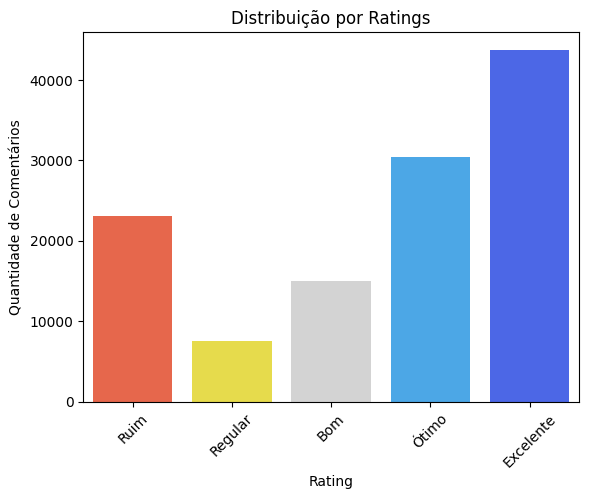

In [25]:
# Gráfico de Colunas que Apresenta a Distribuição dos Ratings

# Cria uma paleta de cores personalizada
custom_palette = sns.color_palette(["#FF5733", "#fff133", "#d3d3d3", "#33acff", "#3357FF"])

# Define the order for the x-axis categories
order = ["Ruim", "Regular", "Bom", "Ótimo", "Excelente"]

# Plota Gráfico com a ordem especificada
sns.countplot(x='customer_review_rating', data=development_sample, palette=custom_palette, order=order)
plt.title('Distribuição por Ratings')
plt.xlabel('Rating')
plt.ylabel('Quantidade de Comentários')
plt.xticks(rotation=45)  # Optional: Rotate x-axis labels for better readability
plt.show()

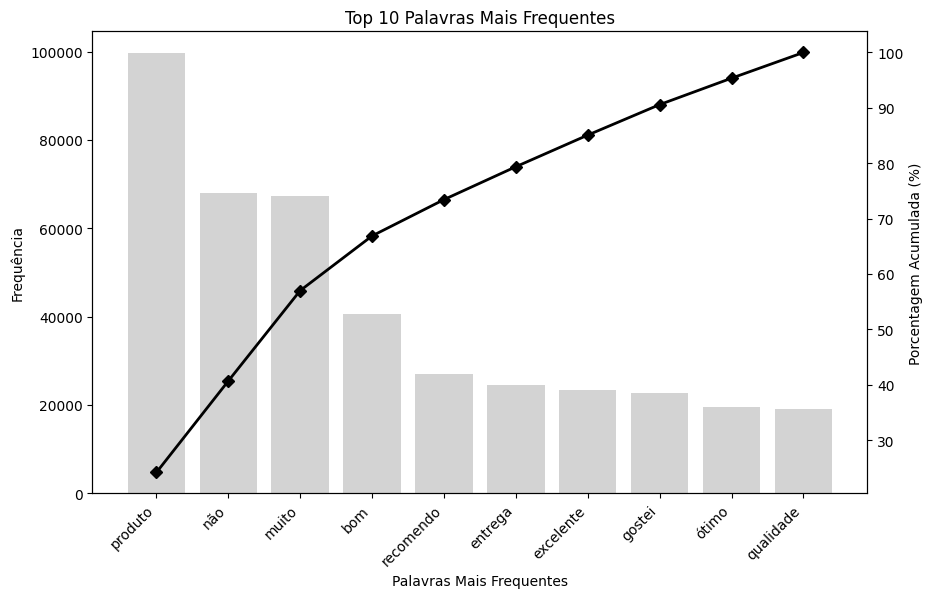

In [26]:
# Contar a frequência das palavras
all_tokens = [token for sublist in development_sample['review_text_tokenized'] for token in sublist]
word_freq = Counter(all_tokens)

# Pegar as 10 palavras mais frequentes
most_common_words = word_freq.most_common(10)

# Separar palavras e frequências
words, freqs = zip(*most_common_words)

# Calcular a porcentagem acumulada
freqs_cumsum = np.cumsum(freqs)  # Soma acumulada das frequências
total_freq = sum(freqs)  # Soma total das frequências
percent_cumsum = 100 * freqs_cumsum / total_freq  # Porcentagem acumulada

# Criar gráfico de Pareto
fig, ax1 = plt.subplots(figsize=(10, 6))

# Gráfico de barras para as frequências
ax1.bar(words, freqs, color='lightgray')
ax1.set_xlabel('Palavras Mais Frequentes')
ax1.set_ylabel('Frequência')
ax1.set_title('Top 10 Palavras Mais Frequentes')

# Adicionar o eixo secundário para a linha acumulada
ax2 = ax1.twinx()
ax2.plot(words, percent_cumsum, color='black', marker='D', linestyle='-', linewidth=2)
ax2.set_ylabel('Porcentagem Acumulada (%)', color='black')

# Ajustar as etiquetas do eixo X com rotação de 45 graus
ax1.set_xticks(range(len(words)))  # Define as posições no eixo X
ax1.set_xticklabels(words, rotation=45, ha='right')  # Rotaciona e ajusta o alinhamento

# Exibir o gráfico
plt.show()

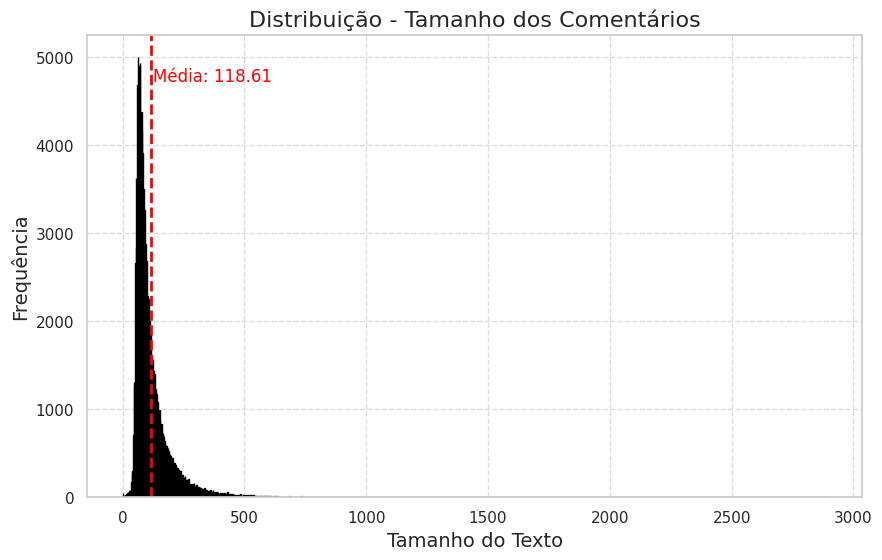

In [27]:
# Algumas estatísticas básicas sobre o tamanho de cada comentário
import matplotlib.pyplot as plt
import seaborn as sns

# Identifica tamanho do texto
development_sample['review_length'] = development_sample['review_text_preprocessed'].apply(len)

# Definir um estilo agradável para o gráfico
sns.set(style="whitegrid")

# Criar o histograma com melhorias visuais
plt.figure(figsize=(10, 6))  # Ajusta o tamanho do gráfico
ax = development_sample['review_length'].hist(bins='auto', edgecolor='black', color='skyblue')

# Adicionar título e rótulos
plt.title('Distribuição - Tamanho dos Comentários', fontsize=16)
plt.xlabel('Tamanho do Texto', fontsize=14)
plt.ylabel('Frequência', fontsize=14)

# Adicionar uma grade para facilitar a leitura
plt.grid(True, linestyle='--', alpha=0.7)

# Mostrar a linha de média
mean = development_sample['review_length'].mean()
plt.axvline(mean, color='red', linestyle='dashed', linewidth=2)
plt.text(mean + 5, plt.ylim()[1] * 0.9, f'Média: {mean:.2f}', color = 'red', fontsize=12)

# Mostrar o gráfico
plt.show()


In [28]:
# Filtrar registros com avaliação 'Regular' e selecionar 10 aleatórios
amostra_regular = development_sample[development_sample['customer_review_rating'] == 'Regular'].sample(n=10, random_state=99)

# Exibir a amostra
display(HTML(amostra_regular.to_html(max_rows=5)))


,review_text,overall_rating,recommend_to_a_friend,site_category_lv1,site_category_lv2,review_title,reviewer_state,reviewer_gender,customer_review_text,review_text_preprocessed,customer_review_rating,tokens_list_tmp,review_text_tokenized,review_length
35377,"produto não veio com o cabo USB , se não e wifi - tem que vir com o cabo e nada no anuncio especifica que ele não vem",2,No,Informática e Acessórios,Impressora,nao veio cabo usb estou fazendo a reclamaçao,SP,M,"nao veio cabo usb estou fazendo a reclamaçao produto não veio com o cabo USB , se não e wifi - tem que vir com o cabo e nada no anuncio especifica que ele não vem",nao veio cabo usb fazendo reclamaçao produto não veio cabo usb não wifi vir cabo nada anuncio especifica não vem,Regular,"[nao, veio, cabo, usb, estou, fazendo, a, reclamaçao, produto, não, veio, com, o, cabo, usb, se, não, e, wifi, tem, que, vir, com, o, cabo, e, nada, no, anuncio, especifica, que, ele, não, vem]","[nao, veio, cabo, usb, fazendo, reclamaçao, produto, não, veio, cabo, usb, não, wifi, vir, cabo, nada, anuncio, especifica, não, vem]",112
122194,"A película, não cobre toda a tela do celular. Fica sobrando. Não sei se todas são assim mesmo, porque eu não achei na minha cidade para comprar. A capinha de silicone, é ótima. Aproveitei que ela é incolor, e coloquei fotos nela. Ficou legal.",2,Yes,Celulares e Smartphones,Acessórios para Celular,Bom,MG,F,"Bom A película, não cobre toda a tela do celular. Fica sobrando. Não sei se todas são assim mesmo, porque eu não achei na minha cidade para comprar. A capinha de silicone, é ótima. Aproveitei que ela é incolor, e coloquei fotos nela. Ficou legal.",bom película não cobre toda tela celular fica sobrando não sei todas assim porque não achei cidade comprar capinha silicone ótima aproveitei incolor coloquei fotos nela ficou legal,Regular,"[bom, a, película, não, cobre, toda, a, tela, do, celular, fica, sobrando, não, sei, se, todas, são, assim, mesmo, porque, eu, não, achei, na, minha, cidade, para, comprar, a, capinha, de, silicone, é, ótima, aproveitei, que, ela, é, incolor, e, coloquei, fotos, nela, ficou, legal]","[bom, película, não, cobre, toda, tela, celular, fica, sobrando, não, sei, todas, assim, porque, não, achei, cidade, comprar, capinha, silicone, ótima, aproveitei, incolor, coloquei, fotos, nela, ficou, legal]",180
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57509,"Infelizmente não posso avaliar o produto, pois ainda não o recebi. O prazo de entrega está atrasando minha reforma.",2,No,Casa e Construção,Cozinhas e Áreas de Serviço,Não recebi o produto,SP,F,"Não recebi o produto Infelizmente não posso avaliar o produto, pois ainda não o recebi. O prazo de entrega está atrasando minha reforma.",não recebi produto infelizmente não posso avaliar produto pois ainda não recebi prazo entrega atrasando reforma,Regular,"[não, recebi, o, produto, infelizmente, não, posso, avaliar, o, produto, pois, ainda, não, o, recebi, o, prazo, de, entrega, está, atrasando, minha, reforma]","[não, recebi, produto, infelizmente, não, posso, avaliar, produto, pois, ainda, não, recebi, prazo, entrega, atrasando, reforma]",111
58188,"Teclado é mais do mesmo, não difere muito dos convencionais, o mouse é bom, tem uma boa sensibilidade.",2,Yes,Games,Jogos para PC e Acessórios,mouse bom teclado ruim,SP,M,"mouse bom teclado ruim Teclado é mais do mesmo, não difere muito dos convencionais, o mouse é bom, tem uma boa sensibilidade.",mouse bom teclado ruim teclado não difere muito convencionais mouse bom boa sensibilidade,Regular,"[mouse, bom, teclado, ruim, teclado, é, mais, do, mesmo, não, difere, muito, dos, convencionais, o, mouse, é, bom, tem, uma, boa, sensibilidade]","[mouse, bom, teclado, ruim, teclado, não, difere, muito, convencionais, mouse, bom, boa, sensibilidade]",89


In [29]:
# Filtrar registros com avaliação 'Bom' e selecionar 10 aleatórios
amostra_bom = development_sample[development_sample['customer_review_rating'] == 'Bom'].sample(n=10, random_state=99)

# Exibir a amostra
display(HTML(amostra_bom.to_html(max_rows=5)))

,review_text,overall_rating,recommend_to_a_friend,site_category_lv1,site_category_lv2,review_title,reviewer_state,reviewer_gender,customer_review_text,review_text_preprocessed,customer_review_rating,tokens_list_tmp,review_text_tokenized,review_length
82405,"Qualidade do material de péssima qualidade, madeira empenadas",3,Yes,Móveis,Guarda-Roupa,não gostei,MG,M,"não gostei Qualidade do material de péssima qualidade, madeira empenadas",não gostei qualidade material péssima qualidade madeira empenadas,Bom,"[não, gostei, qualidade, do, material, de, péssima, qualidade, madeira, empenadas]","[não, gostei, qualidade, material, péssima, qualidade, madeira, empenadas]",65
117827,a qualidade de imagem e Boa o som é bom so que merecia a tecnologia 3d e o controle Magic control,3,Yes,TV e Home Theater,TV,podia ser melhor,SP,M,podia ser melhor a qualidade de imagem e Boa o som é bom so que merecia a tecnologia 3d e o controle Magic control,podia melhor qualidade imagem boa som bom so merecia tecnologia d controle magic control,Bom,"[podia, ser, melhor, a, qualidade, de, imagem, e, boa, o, som, é, bom, so, que, merecia, a, tecnologia, d, e, o, controle, magic, control]","[podia, melhor, qualidade, imagem, boa, som, bom, so, merecia, tecnologia, d, controle, magic, control]",88
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37415,"Imagem muito boa, tempo de resposta bom, aplicativos smart poderiam ser melhores",3,Yes,TV e Home Theater,TV,Bom,SC,M,"Bom Imagem muito boa, tempo de resposta bom, aplicativos smart poderiam ser melhores",bom imagem muito boa tempo resposta bom aplicativos smart poderiam melhores,Bom,"[bom, imagem, muito, boa, tempo, de, resposta, bom, aplicativos, smart, poderiam, ser, melhores]","[bom, imagem, muito, boa, tempo, resposta, bom, aplicativos, smart, poderiam, melhores]",75
16262,Eu gostei do produto ! da para organizar os armarios .,3,Yes,Móveis,Jardineira,Gostei do produto !,SP,F,Gostei do produto ! Eu gostei do produto ! da para organizar os armarios .,gostei produto gostei produto organizar armarios,Bom,"[gostei, do, produto, eu, gostei, do, produto, da, para, organizar, os, armarios]","[gostei, produto, gostei, produto, organizar, armarios]",48


In [30]:
# Obter valores distintos da coluna 'site_category_lv1'
valores_unicos_site_category_lv1 = development_sample['site_category_lv1'].unique()

# Converter para um dataframe
unique_site_category_lv1_df = pd.DataFrame(valores_unicos_site_category_lv1, columns=['site_category_lv1'])

# Exibir a amostra
print(unique_site_category_lv1_df)

                 site_category_lv1
0                      Informática
1            Utilidades Domésticas
2                  Eletroportáteis
3                       Brinquedos
4                TV e Home Theater
5          Celulares e Smartphones
6                Casa e Construção
7                             Moda
8               Malas e Acessórios
9                           Móveis
10             Alimentos e Bebidas
11                      Automotivo
12            Câmeras e Filmadoras
13             Vestuário Esportivo
14        Informática e Acessórios
15                           Games
16                 Esporte e Lazer
17                          Livros
18             Beleza e Perfumaria
19                           Áudio
20                       Papelaria
21                        Relógios
22           Instrumentos Musicais
23              Cama, Mesa e Banho
24            Ferramentas e Jardim
25                 Filmes e Séries
26                Eletrodomésticos
27                  

In [31]:
# Obter valores distintos da coluna 'site_category_lv2'
valores_unicos_site_category_lv2 = development_sample['site_category_lv2'].unique()

# Converter para um dataframe
unique_site_category_lv2_df = pd.DataFrame(valores_unicos_site_category_lv2, columns=['site_category_lv2'])

# Exibir a amostra
print(unique_site_category_lv2_df)

          site_category_lv2
0                  Notebook
1    Copos, Taças e Canecas
2           Panela Elétrica
3     Veículos de Brinquedo
4                        TV
..                      ...
706       Gestão de Armazém
707                 PS Vita
708         Pães e Torradas
709       Indústria Química
710     Literatura Infantil

[711 rows x 1 columns]


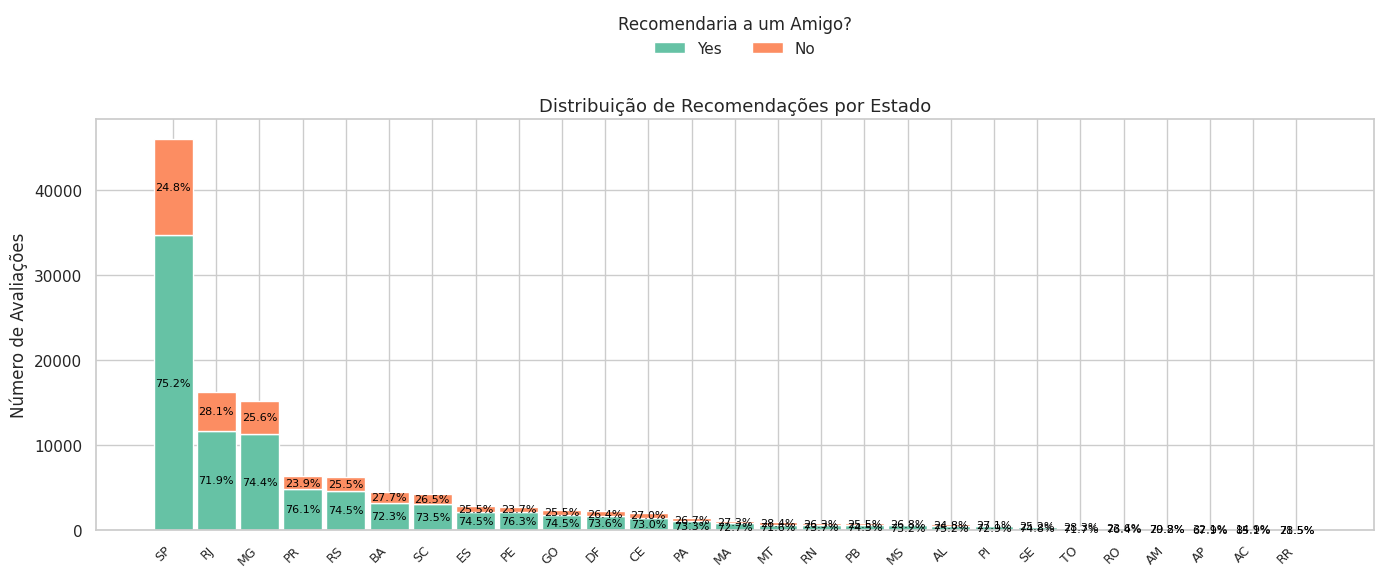

In [32]:
# Agrupar e pivotar os dados
df_agrupado = development_sample.groupby(['reviewer_state', 'recommend_to_a_friend']).size().reset_index(name='count')
df_pivot = df_agrupado.pivot(index='reviewer_state', columns='recommend_to_a_friend', values='count').fillna(0)

# Calcular percentuais
df_percent = df_pivot.div(df_pivot.sum(axis=1), axis=0) * 100

# Ordenar pela soma total
df_pivot['total'] = df_pivot.sum(axis=1)
df_pivot = df_pivot.sort_values(by='total', ascending=False)
df_percent = df_percent.loc[df_pivot.index]  # Manter a mesma ordem

# Posições no eixo X
x = np.arange(len(df_pivot))

# Plot
fig, ax = plt.subplots(figsize=(14, 6))

# Barras empilhadas
yes_counts = df_pivot.get('Yes', 0)
no_counts = df_pivot.get('No', 0)

bars_yes = ax.bar(x, yes_counts, label='Yes', color='#66c2a5', width=0.9)
bars_no = ax.bar(x, no_counts, bottom=yes_counts, label='No', color='#fc8d62', width=0.9)

# Rótulos de percentual em cada barra
for i, state in enumerate(df_pivot.index):
    yes_pct = df_percent.loc[state].get('Yes', 0)
    no_pct = df_percent.loc[state].get('No', 0)
    yes_val = yes_counts.iloc[i]
    no_val = no_counts.iloc[i]

    if yes_val > 0:
        ax.text(i, yes_val / 2, f"{yes_pct:.1f}%", ha='center', va='center', fontsize=8, color='black')
    if no_val > 0:
        ax.text(i, yes_val + no_val / 2, f"{no_pct:.1f}%", ha='center', va='center', fontsize=8, color='black')

# Rótulos e ajustes
ax.set_xticks(x)
ax.set_xticklabels(df_pivot.index, rotation=45, ha='right', fontsize=9)
ax.set_ylabel('Número de Avaliações')
ax.set_title('Distribuição de Recomendações por Estado', fontsize=13)

# Legenda abaixo do título
ax.legend(
    title='Recomendaria a um Amigo?',
    loc='lower center',
    bbox_to_anchor=(0.5, 1.12),
    ncol=2,
    frameon=False
)

plt.tight_layout()
plt.show()

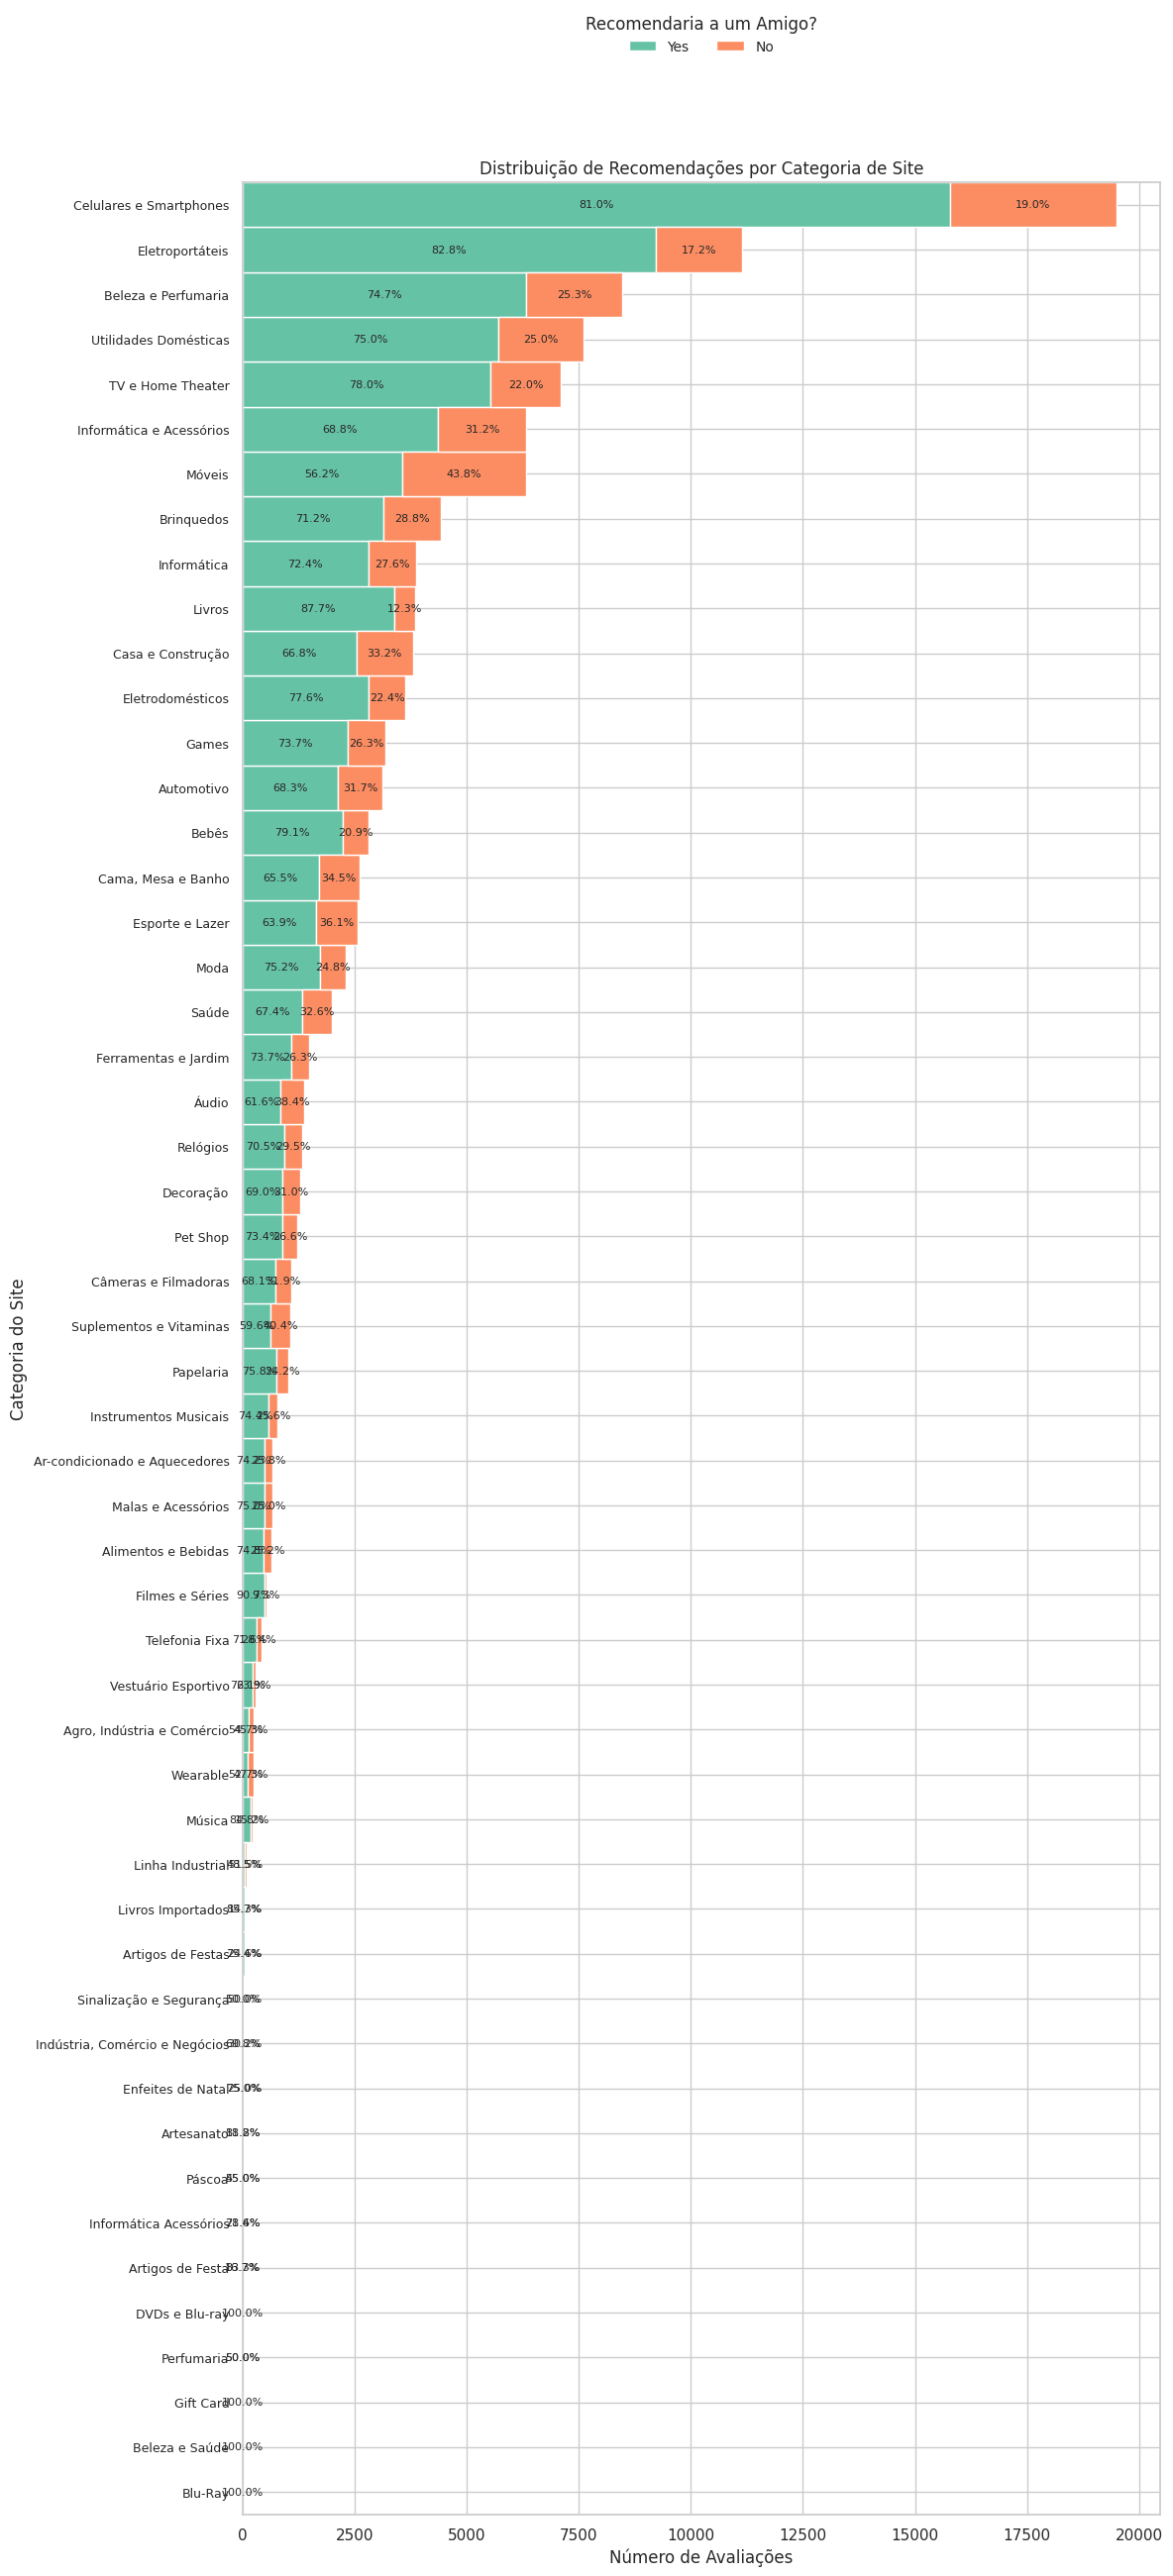

In [33]:
# Agrupar e pivotar os dados
df_agrupado = development_sample.groupby(['site_category_lv1', 'recommend_to_a_friend']).size().reset_index(name='count')
df_pivot = df_agrupado.pivot(index='site_category_lv1', columns='recommend_to_a_friend', values='count').fillna(0)

# Calcular percentuais
df_percent = df_pivot.div(df_pivot.sum(axis=1), axis=0) * 100

# Ordenar pela soma total
df_pivot['total'] = df_pivot.sum(axis=1)
df_pivot = df_pivot.sort_values(by='total', ascending=True)
df_percent = df_percent.loc[df_pivot.index]  # Reordenar igual

# Criar posição com espaçamento maior entre barras
num_categorias = len(df_pivot)
y_pos = np.arange(num_categorias) * 1  # Espaço maior entre barras

# Plotar gráfico
fig, ax = plt.subplots(figsize=(12, num_categorias * 0.5))

# Barras
bars_yes = ax.barh(y_pos, df_pivot.get('Yes', 0), label='Yes', color='#66c2a5', height=1)
bars_no = ax.barh(y_pos, df_pivot.get('No', 0), left=df_pivot.get('Yes', 0), label='No', color='#fc8d62', height=1)

# Rótulos de percentual
for i, category in enumerate(df_pivot.index):
    yes_val = df_percent.loc[category].get('Yes', 0)
    no_val = df_percent.loc[category].get('No', 0)
    x_yes = df_pivot.loc[category].get('Yes', 0)
    x_no = df_pivot.loc[category].get('No', 0)

    if x_yes > 0:
        ax.text(x_yes / 2, y_pos[i], f"{yes_val:.1f}%", va='center', ha='center', fontsize=8)
    if x_no > 0:
        ax.text(x_yes + x_no / 2, y_pos[i], f"{no_val:.1f}%", va='center', ha='center', fontsize=8)

# Ajustar rótulos do eixo Y
ax.set_yticks(y_pos)
ax.set_yticklabels(df_pivot.index, fontsize=9)

# Título e eixos
ax.set_title('Distribuição de Recomendações por Categoria de Site', fontsize=12)
ax.set_xlabel('Número de Avaliações')
ax.set_ylabel('Categoria do Site')
ax.legend(
    title='Recomendaria a um Amigo?',
    fontsize=10,
    loc='lower center',
    bbox_to_anchor=(0.5, 1.05),  # posição central acima do eixo X
    ncol=2,  # número de colunas na legenda, ajusta para ficar mais compacta
    frameon=False
)
ax.set_ylim(y_pos[0] - 0.5, y_pos[-1] + 0.5)
plt.tight_layout()
plt.show()

### Processo de Lematização

In [34]:
# Instala modelo de lematização em português do spaCy
!python -m spacy download pt_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 114.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [35]:
# Na Lematização, reduzimos a palavra à sua forma base (lema), sempre resultando
# em um termo válido na gramática.
# Diferente do Stemming, a Lematização considera a classe gramatical da palavra
# para a redução.
# Em Análise de Sentimentos, onde a precisão semântica é crucial, a Lematização
# é mais indicada que o Stemming, pois preserva melhor o contexto e o significado.
# Vamos usar a biblioteca spaCy para aplicar essa técnica.

# Carregando o modelo de lematização do spaCy para português
import spacy
nlp = spacy.load("pt_core_news_sm")

# Função para aplicar Lematização
def lemmatization(tokens):
    # Converte a lista de tokens de volta para uma string
    text = " ".join(tokens)
    doc = nlp(text)  # Processando o texto com o spaCy
    lemmatized_tokens = [token.lemma_ for token in doc]  # Extraindo as lemas de cada token
    return " ".join(lemmatized_tokens)  # Retornando dados como string

# Aplicando a Lematização
development_sample['review_text_lemmatized'] = development_sample['review_text_tokenized'].apply(lemmatization)

In [36]:
display(HTML(development_sample.to_html(max_rows=20)))

,review_text,overall_rating,recommend_to_a_friend,site_category_lv1,site_category_lv2,review_title,reviewer_state,reviewer_gender,customer_review_text,review_text_preprocessed,customer_review_rating,tokens_list_tmp,review_text_tokenized,review_length,review_text_lemmatized
0,Estou contente com a compra entrega rápida o único problema com as Americanas é se houver troca ou devolução do produto o consumidor tem problemas com espera.,4,Yes,Informática,Notebook,Bom,RJ,F,Bom Estou contente com a compra entrega rápida o único problema com as Americanas é se houver troca ou devolução do produto o consumidor tem problemas com espera.,bom contente compra entrega rápida único problema americanas troca devolução produto consumidor problemas espera,Ótimo,"[bom, estou, contente, com, a, compra, entrega, rápida, o, único, problema, com, as, americanas, é, se, houver, troca, ou, devolução, do, produto, o, consumidor, tem, problemas, com, espera]","[bom, contente, compra, entrega, rápida, único, problema, americanas, troca, devolução, produto, consumidor, problemas, espera]",112,bom contente compra entregar rápido único problema americano troca devolução produto consumidor problema esperar
1,"Por apenas R$1994.20,eu consegui comprar esse lindo copo de acrílico.",4,Yes,Utilidades Domésticas,"Copos, Taças e Canecas","Preço imbatível, ótima qualidade",SC,M,"Preço imbatível, ótima qualidade Por apenas R$1994.20,eu consegui comprar esse lindo copo de acrílico.",preço imbatível ótima qualidade apenas r consegui comprar lindo copo acrílico,Ótimo,"[preço, imbatível, ótima, qualidade, por, apenas, r, eu, consegui, comprar, esse, lindo, copo, de, acrílico]","[preço, imbatível, ótima, qualidade, apenas, r, consegui, comprar, lindo, copo, acrílico]",77,preço imbatível ótimo qualidade apenas elr conseguir comprar lir copo acrílico
2,"SUPERA EM AGILIDADE E PRATICIDADE OUTRAS PANELAS ELÉTRICAS. COSTUMO USAR OUTRA PANELA PARA COZIMENTO DE ARROZ (JAPONESA), MAS LEVA MUITO TEMPO, +/- 50 MINUTOS. NESSA PANELA É MUITO MAIS RÁPIDO, EXATAMENTE 6 MINUTOS. EU RECOMENDO.",4,Yes,Eletroportáteis,Panela Elétrica,ATENDE TODAS AS EXPECTATIVA.,SP,M,"ATENDE TODAS AS EXPECTATIVA. SUPERA EM AGILIDADE E PRATICIDADE OUTRAS PANELAS ELÉTRICAS. COSTUMO USAR OUTRA PANELA PARA COZIMENTO DE ARROZ (JAPONESA), MAS LEVA MUITO TEMPO, +/- 50 MINUTOS. NESSA PANELA É MUITO MAIS RÁPIDO, EXATAMENTE 6 MINUTOS. EU RECOMENDO.",atende todas expectativa supera agilidade praticidade outras panelas elétricas costumo usar outra panela cozimento arroz japonesa mas leva muito tempo minutos nessa panela muito rápido exatamente minutos recomendo,Ótimo,"[atende, todas, as, expectativa, supera, em, agilidade, e, praticidade, outras, panelas, elétricas, costumo, usar, outra, panela, para, cozimento, de, arroz, japonesa, mas, leva, muito, tempo, minutos, nessa, panela, é, muito, mais, rápido, exatamente, minutos, eu, recomendo]","[atende, todas, expectativa, supera, agilidade, praticidade, outras, panelas, elétricas, costumo, usar, outra, panela, cozimento, arroz, japonesa, mas, leva, muito, tempo, minutos, nessa, panela, muito, rápido, exatamente, minutos, recomendo]",213,atender todo expectativa superar agilidader praticidade outro panela elétrica costumo usar outro panela cozimento arroz japonês mas levar muito tempo minuto em esse panela muito rápido exatamente minuto recomer
3,MEU FILHO AMOU! PARECE DE VERDADE COM TANTOS DETALHES QUE TÊM!,4,Yes,Brinquedos,Veículos de Brinquedo,presente mais que desejado,SP,F,presente mais que desejado MEU FILHO AMOU! PARECE DE VERDADE COM TANTOS DETALHES QUE TÊM!,presente desejado filho amou parece verdade tantos detalhes têm,Ótimo,"[presente, mais, que, desejado, meu, filho, amou, parece, de, verdade, com, tantos, detalhes, que, têm]","[presente, desejado, filho, amou, parece, verdade, tantos, detalhes, têm]",63,presente desejar filho amar parecer verdade tanto detalhe ter
4,"A entrega foi no prazo, as americanas estão de parabéns. A smart tv é muito boa, a navegação n

### Definição da Variável Dependente

In [37]:
# O dataset apresenta o atributo "recommend_to_a_friend", o qual contempla os
# valores "Yes" ou "No".
# Estamos utilizando este atributo para definirmos a variável binária dependente, onde:
# Yes = 1
# No = 0

development_sample['target'] = development_sample['recommend_to_a_friend'].map({'Yes': 1, 'No': 0})

# Exibir as primeiras linhas do dataframe para verificar a nova variável 'target'
display(HTML(development_sample.to_html(max_rows=5)))

,review_text,overall_rating,recommend_to_a_friend,site_category_lv1,site_category_lv2,review_title,reviewer_state,reviewer_gender,customer_review_text,review_text_preprocessed,customer_review_rating,tokens_list_tmp,review_text_tokenized,review_length,review_text_lemmatized,target
0,Estou contente com a compra entrega rápida o único problema com as Americanas é se houver troca ou devolução do produto o consumidor tem problemas com espera.,4,Yes,Informática,Notebook,Bom,RJ,F,Bom Estou contente com a compra entrega rápida o único problema com as Americanas é se houver troca ou devolução do produto o consumidor tem problemas com espera.,bom contente compra entrega rápida único problema americanas troca devolução produto consumidor problemas espera,Ótimo,"[bom, estou, contente, com, a, compra, entrega, rápida, o, único, problema, com, as, americanas, é, se, houver, troca, ou, devolução, do, produto, o, consumidor, tem, problemas, com, espera]","[bom, contente, compra, entrega, rápida, único, problema, americanas, troca, devolução, produto, consumidor, problemas, espera]",112,bom contente compra entregar rápido único problema americano troca devolução produto consumidor problema esperar,1
1,"Por apenas R$1994.20,eu consegui comprar esse lindo copo de acrílico.",4,Yes,Utilidades Domésticas,"Copos, Taças e Canecas","Preço imbatível, ótima qualidade",SC,M,"Preço imbatível, ótima qualidade Por apenas R$1994.20,eu consegui comprar esse lindo copo de acrílico.",preço imbatível ótima qualidade apenas r consegui comprar lindo copo acrílico,Ótimo,"[preço, imbatível, ótima, qualidade, por, apenas, r, eu, consegui, comprar, esse, lindo, copo, de, acrílico]","[preço, imbatível, ótima, qualidade, apenas, r, consegui, comprar, lindo, copo, acrílico]",77,preço imbatível ótimo qualidade apenas elr conseguir comprar lir copo acrílico,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132371,"Material fraco, poderia ser melhor. Ficou devendo na minha opinião.",1,No,Papelaria,Material de Escritório,O produto não é bom.,RJ,M,"O produto não é bom. Material fraco, poderia ser melhor. Ficou devendo na minha opinião.",produto não bom material fraco poderia melhor ficou devendo opinião,Ruim,"[o, produto, não, é, bom, material, fraco, poderia, ser, melhor, ficou, devendo, na, minha, opinião]","[produto, não, bom, material, fraco, poderia, melhor, ficou, devendo, opinião]",67,produto não bom material fraco poder bom ficar dever opinião,0
132372,"Comprei esse produto, quando chegou estava com avaria. Devolvi, já vai fazer 3 meses, não me enviaram o produto e nem o estorno.",1,No,Decoração,Painel de Fotos,Produto não entregue,ES,F,"Produto não entregue Comprei esse produto, quando chegou estava com avaria. Devolvi, já vai fazer 3 meses, não me enviaram o produto e nem o estorno.",produto não entregue comprei produto chegou avaria devolvi vai fazer meses não enviaram produto nem estorno,Ruim,"[produto, não, entregue, comprei, esse, produto, quando, chegou, estava, com, avaria, devolvi, já, vai, fazer, meses, não, me, enviaram, o, produto, e, nem, o, estorno]","[produto, não, entregue, comprei, produto, chegou, avaria, devolvi, vai, fazer, meses, não, enviaram, produto, nem, estorno]",107,produto não entregar comprei produto chegar avario devolvi ir fazer mês não enviar produto nem estorno,0


In [38]:
# Passo 2: Define 0 caminho onde o dataframe será salvo no Google Drive
save_path = '/content/drive/My Drive/ICMC/PLN/development_sample.pkl'

#DataFrame será salvo na pasta de trabalho local para analise das métricas do modelo simbólico
save_path = 'development_sample.pkl'


# Passo 3: Salva o dataframe utilizando pickle
development_sample.to_pickle(save_path)
print(f"DataFrame exportado com sucesso para {save_path}")

DataFrame exportado com sucesso para development_sample.pkl


### Análise de Desbalanceamento

Contagem das classes:
target
1    88997
0    30759
Name: count, dtype: int64

Proporção das classes:
target
1    0.743153
0    0.256847
Name: proportion, dtype: float64


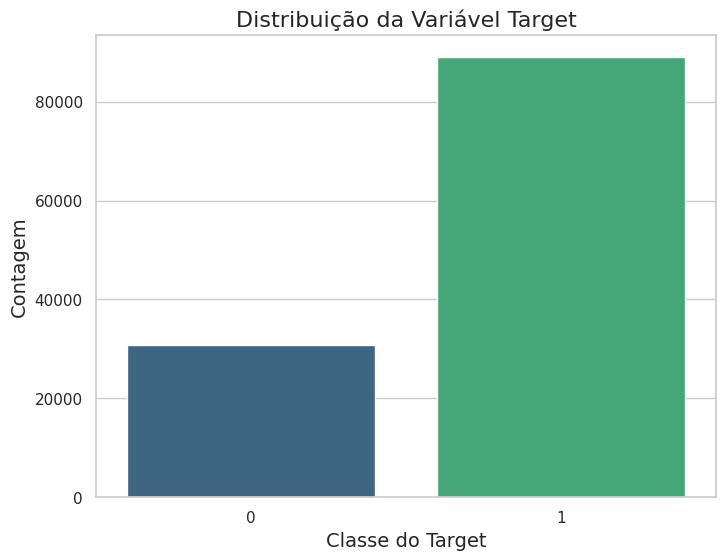

In [39]:
# Contar a frequência de cada valor na variável 'target'
class_counts = development_sample['target'].value_counts()

# Exibir as contagens
print("Contagem das classes:")
print(class_counts)

# Calcular a proporção de cada classe
class_proportions = development_sample['target'].value_counts(normalize=True)
print("\nProporção das classes:")
print(class_proportions)

# Plotar gráfico de barras para a distribuição das classes
plt.figure(figsize=(8, 6))
sns.countplot(x='target', data=development_sample, palette='viridis')

# Adicionar título e rótulos
plt.title('Distribuição da Variável Target', fontsize=16)
plt.xlabel('Classe do Target', fontsize=14)
plt.ylabel('Contagem', fontsize=14)

# Exibir o gráfico
plt.show()

### Vetorizar Texto Utilizando o modelo Word2Vec

In [40]:
# Passo 1: Treinar o modelo Word2Vec

# Criar uma lista de listas de palavras a partir dos textos lematizados
sentences = [text.split() for text in development_sample['review_text_lemmatized']]

# Treinar o modelo Word2Vec
# Parâmetros principais:
# - sentences: lista de listas de palavras (texto tokenizado), usado para o modelo
# aprender relações semânticas.
# - vector_size: tamanho dos vetores de palavras (ex: 300 dimensões).
# - window: número de palavras de contexto consideradas à esquerda e à direita
# (ex: 10 de cada lado).
# - min_count: frequência mínima para uma palavra ser incluída no vocabulário
# (ex: palavras que aparecem pelo menos 1 vez).
# - workers: número de threads para acelerar o treinamento.

model_w2v = Word2Vec(sentences, vector_size=300, window=10, min_count=1, workers=4)

# Passo 2: Representar documentos como a média dos vetores das palavras

def document_vector(doc):
    # Mantém apenas palavras presentes no vocabulário do modelo
    doc = [word for word in doc.split() if word in model_w2v.wv]
    # Retorna a média dos vetores das palavras ou um vetor de zeros se o documento estiver vazio
    return np.mean(model_w2v.wv[doc], axis=0) if doc else np.zeros(model_w2v.vector_size)

# Gerar vetores para todos os documentos
X = np.array([document_vector(text) for text in development_sample['review_text_lemmatized']])

# Passo 3: Definir as labels (variável alvo)
y = development_sample['target']


### Divisão dos dados - Treino e Teste

In [41]:
from sklearn.model_selection import train_test_split

# Dividir o dataset em treino e teste (80% treino, 20% teste)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Verificar a distribuição das classes antes do SMOTE
print(f'Distribuição original do treino:\n{y_train.value_counts()}')

Distribuição original do treino:
target
1    71109
0    24695
Name: count, dtype: int64


### Balanceamento de Classes

In [42]:
from imblearn.over_sampling import SMOTE, ADASYN
import pandas as pd

SEED = 42

# Aplicar SMOTE
smote = SMOTE(random_state=SEED)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("Distribuição após SMOTE:")
print(pd.Series(y_train_resampled).value_counts())

# Aplicar ADASYN (balanceamento automático)
# adasyn = ADASYN(random_state=SEED, n_neighbors=5)
# X_resampled, y_resampled = adasyn.fit_resample(X_train, y_train)

# print("\nDistribuição após ADASYN:")
# print(pd.Series(y_resampled).value_counts())


Distribuição após SMOTE:
target
0    71109
1    71109
Name: count, dtype: int64


In [43]:
X_train_resampled.shape, y_train_resampled.shape, X_test.shape, y_test.shape

((142218, 300), (142218,), (23952, 300), (23952,))

# Modelos de Aprendizado de Máquina - Supervisionados

In [44]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, roc_curve, auc
import matplotlib.pyplot as plt

# Instanciar os modelos

# a) Regressão Logística
logistic_regression_model = LogisticRegression(max_iter=200, random_state=42)

# b) Random Forest
random_forest_model = RandomForestClassifier(n_estimators=100, random_state=42)

# c) Gradient Boosting
gradient_boosting_model = GradientBoostingClassifier(n_estimators=100, random_state=42)

#### Regressão Logística

In [45]:
import time

# Inicializa lista para computar o tempo de processamento de cada algoritmo
tempo_processamento = []

In [46]:
start_time = time.time()
logistic_regression_model.fit(X_train_resampled, y_train_resampled)
end_time = time.time()
tempo_processamento.append({"Modelo": "Regressão Logística", "Tempo de Processamento": end_time - start_time})

#### Random Forest

In [47]:
random_forest_model.fit(X_train_resampled, y_train_resampled)
end_time = time.time()
tempo_processamento.append({"Modelo": "Random Forest", "Tempo de Processamento": end_time - start_time})

#### Gradient Boosting

In [48]:
start_time = time.time()
gradient_boosting_model.fit(X_train_resampled, y_train_resampled)
end_time = time.time()
tempo_processamento.append({"Modelo": "Gradient Boosting", "Tempo de Processamento": end_time - start_time})

#### Armazena Tempos de Processamento

In [49]:
# Armazena os tempos de processamento num dataframe
tempo_processamento_df = pd.DataFrame(tempo_processamento)

# Salvar os tempos de processamento para o Google Drive
save_path = '/content/drive/My Drive/ICMC/PLN/tempo_processamento.pkl'

# Salva o dataframe utilizando pickle
tempo_processamento_df.to_pickle(save_path)
print(f"DataFrame exportado com sucesso para {save_path}")

# Ler o DataFrame do arquivo pickle
tempo_processamento_df = pd.read_pickle(save_path)

# Mostrar os dados carregados
print("DataFrame carregado do Google Drive:")
print(tempo_processamento_df)

DataFrame exportado com sucesso para /content/drive/My Drive/ICMC/PLN/tempo_processamento.pkl
DataFrame carregado do Google Drive:
                Modelo  Tempo de Processamento
0  Regressão Logística               21.770933
1        Random Forest              688.076053
2    Gradient Boosting             2502.918615


#### Plotando Tempos de Processamento

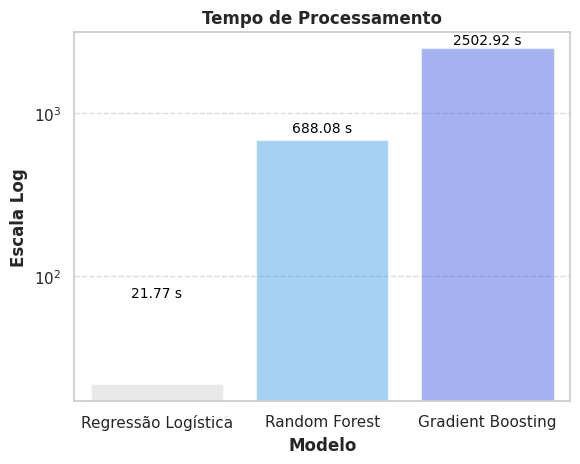

In [50]:
# Cria uma paleta de cores personalizada
custom_palette = sns.color_palette(["#d3d3d3", "#33acff", "#3357FF"])

# Plota Gráfico com a cores personalizadas
ax = sns.barplot(x='Modelo', y='Tempo de Processamento', data=tempo_processamento_df, palette=custom_palette,alpha=0.5)
plt.title('Tempo de Processamento', fontweight='bold')
plt.xlabel('Modelo', fontweight='bold')
plt.ylabel('Escala Log', fontweight='bold')

# Define uma escala log para o eixo 'y' para melhor visualização
plt.yscale('log')

# Adiciona linhas de grade verticais
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adiciona tempos de processamento no rótulo de cada coluna
for i in range(len(tempo_processamento_df)):
    ax.text(i, tempo_processamento_df['Tempo de Processamento'][i] + 50,  # Adjust the y-coordinate as needed
            f"{tempo_processamento_df['Tempo de Processamento'][i]:.2f} s",
            ha='center', va='bottom', fontsize=10, color='black')

plt.show()

#### Salva Modelo de Vetorização no Google Drive

In [51]:
# Salvando o modelo word2vec_model para uso futuro
from gensim.models import Word2Vec
from google.colab import drive

# Seta diretório raíz
drive.mount('/content/drive')

# Define a pasta do projeto
target_folder = "/content/drive/My Drive/ICMC/PLN/Machine_Learning"
target_file = f"{target_folder}/word2vec_model.bin"

# Assegura que o diretório existe. Se não, cria um diretório
import os
if not os.path.exists(target_folder):
    os.makedirs(target_folder)

# Salva o modelo model_w2v para o diretório definido
model_w2v.save(target_file)
print(f"Model saved to {target_file}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model saved to /content/drive/My Drive/ICMC/PLN/Machine_Learning/word2vec_model.bin


#### Salva Modelos de Aprendizado de Máquina Supervisionado no Google Drive

In [52]:
import joblib

# Salva o Modelo de Regressão Logística Utilizando joblib
model_path = f"{target_folder}/logistic_regression_model.joblib"
joblib.dump(logistic_regression_model, model_path)

# Salva o Modelo de Random Forest Utilizando joblib
model_path = f"{target_folder}/random_forest_model.joblib"
joblib.dump(random_forest_model, model_path)

# Salva o Modelo de Gradient Boosting Utilizando joblib
model_path = f"{target_folder}/gradient_boosting_model.joblib"
joblib.dump(gradient_boosting_model, model_path)

['/content/drive/My Drive/ICMC/PLN/Machine_Learning/gradient_boosting_model.joblib']

### Testar os Modelos Supervisionados

Resultados para Logistic Regression:
              precision    recall  f1-score   support

Negative (0)       0.76      0.92      0.84      6064
Positive (1)       0.97      0.90      0.94     17888

    accuracy                           0.91     23952
   macro avg       0.87      0.91      0.89     23952
weighted avg       0.92      0.91      0.91     23952

Resultados para Random Forest:
              precision    recall  f1-score   support

Negative (0)       0.80      0.88      0.84      6064
Positive (1)       0.96      0.93      0.94     17888

    accuracy                           0.91     23952
   macro avg       0.88      0.90      0.89     23952
weighted avg       0.92      0.91      0.92     23952

Resultados para Gradient Boosting:
              precision    recall  f1-score   support

Negative (0)       0.77      0.90      0.83      6064
Positive (1)       0.96      0.91      0.94     17888

    accuracy                           0.91     23952
   macro avg       0.87  

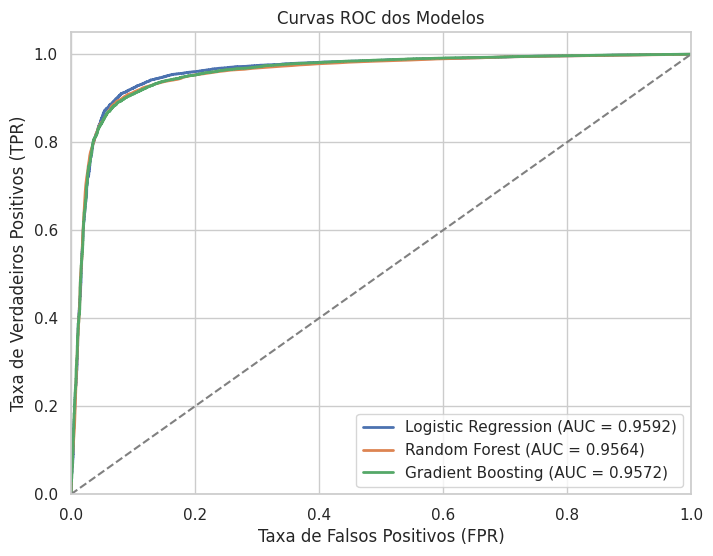

AUC Scores:
Logistic Regression: 0.9592
Random Forest: 0.9564
Gradient Boosting: 0.9572


In [53]:
# Fazer previsões e calcular probabilidades
models = {
    "Logistic Regression": logistic_regression_model
    ,"Random Forest": random_forest_model
    ,"Gradient Boosting": gradient_boosting_model
}

# Inicializar listas para armazenar os resultados
roc_auc_scores = {}
plt.figure(figsize=(8, 6))

# Avaliar todos os modelos
for model_name, model in models.items():
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]  # Probabilidade da classe positiva (1)

    # Gera relatório de classificação
    print(f"Resultados para {model_name}:")
    print(classification_report(y_test, y_pred, target_names=['Negative (0)', 'Positive (1)']))

    # Calcular a curva ROC
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    roc_auc_scores[model_name] = roc_auc

    # Plotar a curva ROC
    plt.plot(fpr, tpr, lw=2, label=f"{model_name} (AUC = {roc_auc:.4f})")

# Configurações do gráfico
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Linha diagonal (classificador aleatório)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
plt.title('Curvas ROC dos Modelos')
plt.legend(loc='lower right')
plt.show()

# Exibir AUC scores
print("AUC Scores:")
for model_name, auc_score in roc_auc_scores.items():
    print(f"{model_name}: {auc_score:.4f}")

### Simular Classificação dos Modelos Supervisionados

In [54]:
# Supondo que o modelo de regressão logística já esteja treinado e o modelo Word2Vec já esteja ajustado.

# Nova frase para avaliação
sentence = "Estou muito satisfeito com o laptop que eu comprei"

# Função para calcular o vetor da nova frase
def preprocess_and_vectorize(sentence):
    # Tokenizar e fazer o pré-processamento (a mesma lógica que você usou para treinar)
    # Aqui você deve aplicar as mesmas etapas de pré-processamento que você usou para o conjunto de treino
    # Exemplo de tokenização e lematização (ajuste conforme seu processamento)
    words = sentence.split()  # Ajuste conforme seu método de tokenização
    words = [word for word in words if word in model_w2v.wv]  # Filtrar palavras que estão no modelo
    if words:
        return np.mean(model_w2v.wv[words], axis=0)
    else:
        return np.zeros(model_w2v.vector_size)

# Calcular o vetor para a nova frase
sentence_vector = preprocess_and_vectorize(sentence)

# Fazer a previsão
# Você precisa transformar o vetor em um formato que o modelo de regressão logística espera
# Aqui estamos usando uma matriz 2D com um único vetor
y_prob = logistic_regression_model.predict_proba([sentence_vector])[0]  # Probabilidades para a nova frase

# Definir a classe prevista
y_pred = logistic_regression_model.predict([sentence_vector])[0]

# Interpretação do resultado
sentiment = "Positivo" if y_pred == 1 else "Negativo"  # Ajuste conforme suas classes

# Exibir os resultados
print(f"Sentimento: {sentiment}")
print(f"Probabilidades: Positivo: {y_prob[1]:.4f}, Negativo: {y_prob[0]:.4f}")


Sentimento: Positivo
Probabilidades: Positivo: 0.9159, Negativo: 0.0841


# Modelo Simbólico

#### Integrando Sentianalyst ao dataset e execução do modelo desenvolvido

In [55]:
import pandas as pd

In [82]:
import sys
sys.path.append('./sentianalyst')

from core import SentimentIntensityAnalyzer

# 4. Analisador
sia = SentimentIntensityAnalyzer()

# 5. Função criada para que possa ser aplicado no Dataset
def analise_sentimento(texto):
    score = sia.polarity_scores(texto)
    return {
        "score": score,
        "sentimento": "positivo" if score > 0.5 else "negativo"
    }


In [83]:
# 6. Análise simbólica
development_sample['resultado_simbólico'] = development_sample['review_text_lemmatized'].apply(analise_sentimento)
development_sample['sentimento_simbólico'] = development_sample['resultado_simbólico'].apply(lambda x: x['sentimento'])
development_sample['score_simbólico'] = development_sample['resultado_simbólico'].apply(lambda x: x['score'])

In [84]:
# Visualizando resultados
development_sample[['review_text_lemmatized', 'sentimento_simbólico','target', 'score_simbólico']].head(100)

,review_text_lemmatized,sentimento_simbólico,target,score_simbólico
0,bom contente compra entregar rápido único prob...,positivo,1,0.600
1,preço imbatível ótimo qualidade apenas elr con...,positivo,1,1.500
2,atender todo expectativa superar agilidader pr...,positivo,1,1.386
3,presente desejar filho amar parecer verdade ta...,positivo,1,3.200
4,duvir excelente entregar prazo americana parab...,positivo,1,13.193
...,...,...,...,...
103,excelente excelente produto esquentar dar form...,positivo,1,10.300
104,achar muito básico gostar pouco aparência prop...,positivo,0,1.500
105,bom produto bom produto feliz semana cheio amo...,positivo,1,11.900
106,excelente produto adorar recomer todo perfeito...,positivo,1,13.093


#### Avaliando métricas

In [88]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [89]:
print(confusion_matrix(development_sample['target'], development_sample['sentimento_simbólico'].map({'positivo': 1, 'negativo': 0})))

[[23083  7676]
 [13399 75598]]


In [90]:
print(classification_report(development_sample['target'], development_sample['sentimento_simbólico'].map({'positivo': 1, 'negativo': 0})))

              precision    recall  f1-score   support

           0       0.63      0.75      0.69     30759
           1       0.91      0.85      0.88     88997

    accuracy                           0.82    119756
   macro avg       0.77      0.80      0.78    119756
weighted avg       0.84      0.82      0.83    119756



#### Salvando resultados

In [111]:
# Define o caminho onde o dataframe será salvo no Google Drive
save_path = '/content/drive/My Drive/ICMC/PLN/development_sample_result.pkl'

# Salva o dataframe utilizando pickle
development_sample.to_pickle(save_path)
print(f"DataFrame exportado com sucesso para {save_path}")

DataFrame exportado com sucesso para /content/drive/My Drive/ICMC/PLN/development_sample_result.pkl


#### Interagindo com o modelo

In [ ]:
import sys
import os
sys.path.append('./sentianalyst')

from core import SentimentIntensityAnalyzer


sia = SentimentIntensityAnalyzer()


def preprocessar_texto(texto):
    #Converter para letras minusculas
    texto = texto.lower()

    #Remover pontuação e adicionar espaço usando expressões regulares (Noise)
    texto = re.sub(r'[^\w\s]', ' ', texto)

    #Remover números
    texto = re.sub(r'\d+', ' ', texto)

    #Remover stopwords
    texto = ' '.join([word for word in texto.split() if word not in (stop_words)])

    #Tokenizar o texto
    texto_tokens = word_tokenize(texto.lower())

    #Aplicando a Lematização
    texto_lematizado = lemmatization(texto_tokens)

    return texto_lematizado

def classificar(score):
    if score > 0.5:
        return "positivo"
    else:
        return "negativo"

# Análise agora inserindo os dados
def analisar_comentario():
    while True:
        texto = input("\nDigite um comentário para analisar (ou 'sair' para terminar): ")

        if texto.lower() == 'sair':
            print("Análise encerrada.")
            break

        texto_lematizado = preprocessar_texto(texto)
        score = sia.polarity_scores(texto_lematizado)
        sentimento = classificar(score)

        print(f"\nComentário: {texto}")
        print(f"Score: {score:.2f}")
        print(f"Sentimento simbólico: {sentimento}")


if __name__ == '__main__':
    analisar_comentario()


1ª Etapa: Modelo Estatístico de Machine Learning

# Modelo de Aprendizado Profundo (Deep Learning)

In [ ]:
# --- 1. Carregamento e Preparação dos Dados ---
print("--- Etapa 1: Carregamento e Preparação dos Dados ---")

# Define caminho do Córpus
url = "https://raw.githubusercontent.com/americanas-tech/b2w-reviews01/main/B2W-Reviews01.csv"

# Lendo o arquivo csv num pandas dataframe
try:
    data = pd.read_csv(url)
    df = pd.DataFrame(data)
    print("DataFrame loaded successfully!")
    print("DataFrame de exemplo criado.")
except Exception as e:
    print(f"An error occurred: {e}")

--- Etapa 1: Carregamento e Preparação dos Dados ---
DataFrame loaded successfully!
DataFrame de exemplo criado.


<ipython-input-3-9ca3c7e8f461>:9: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(url)


In [ ]:
# Cria um novo dataframe chamado "df" contendo apenas os atributos relevantes
# para a análise de sentimentos
df = df[['review_text', 'overall_rating', 'recommend_to_a_friend', 'site_category_lv1', 'site_category_lv2','review_title', 'reviewer_state', 'reviewer_gender']]

In [ ]:
# O atributo "review title", introduz ou sumariza a revisão do cliente, enquanto
# que o atributo "review_text" contempla todo o comentário do cliente sobre um
# determinado produto, seja ele positivo ou negativo. Considerando que ambos os
# atributos expressam uma opinião do cliente, estamos criando um novo campo
# chamado "customer_review_text", o qual contempla as opiniões expressas nestes
# 2 campos.
df['customer_review_text'] = df['review_title'] + ' ' + df['review_text']
df.head(10)

,review_text,overall_rating,recommend_to_a_friend,site_category_lv1,site_category_lv2,review_title,reviewer_state,reviewer_gender,customer_review_text
0,Estou contente com a compra entrega rápida o ú...,4,Yes,Informática,Notebook,Bom,RJ,F,Bom Estou contente com a compra entrega rápida...
1,"Por apenas R$1994.20,eu consegui comprar esse ...",4,Yes,Utilidades Domésticas,"Copos, Taças e Canecas","Preço imbatível, ótima qualidade",SC,M,"Preço imbatível, ótima qualidade Por apenas R$..."
2,SUPERA EM AGILIDADE E PRATICIDADE OUTRAS PANEL...,4,Yes,Eletroportáteis,Panela Elétrica,ATENDE TODAS AS EXPECTATIVA.,SP,M,ATENDE TODAS AS EXPECTATIVA. SUPERA EM AGILIDA...
3,MEU FILHO AMOU! PARECE DE VERDADE COM TANTOS D...,4,Yes,Brinquedos,Veículos de Brinquedo,presente mais que desejado,SP,F,presente mais que desejado MEU FILHO AMOU! PAR...
4,"A entrega foi no prazo, as americanas estão de...",5,Yes,TV e Home Theater,TV,"Sem duvidas, excelente",MG,M,"Sem duvidas, excelente A entrega foi no prazo,..."
5,"Excelente produto, por fora em material acríli...",5,Yes,Utilidades Domésticas,"Copos, Taças e Canecas",Produto imperdível,PA,M,"Produto imperdível Excelente produto, por fora..."
6,"produto mto bom, com essa garrafinha vc pode a...",5,Yes,Utilidades Domésticas,"Copos, Taças e Canecas",ótimo,NaN,NaN,"ótimo produto mto bom, com essa garrafinha vc ..."
7,Produto excelente qualidade boa câmera desenvo...,4,Yes,Celulares e Smartphones,Smartphone,Gostei bastante do produto,GO,M,Gostei bastante do produto Produto excelente q...
8,O barulho e minimo e o vento é bem forte na ve...,5,Yes,Casa e Construção,Climatização,Gostei do produto,SP,M,Gostei do produto O barulho e minimo e o vento...
9,MEU PRODUTO NAO FOI ENTREGUE E A AMERICANAS ES...,1,No,Casa e Construção,Iluminação,NÃO RECEBI O PRODUTO,RJ,M,NÃO RECEBI O PRODUTO MEU PRODUTO NAO FOI ENTRE...


In [ ]:
# Apenas renomeando colunas para facilitar a análise
df = df.rename(columns={'customer_review_text': 'text', 'recommend_to_a_friend': 'label_text'})

In [ ]:
# Efetua algumas limpezas nos dados

print("\nLimpando dados:")

# Verificar quantos NaNs existem na coluna 'text' antes do tratamento
print(f"Valores ausentes na coluna 'text' ANTES do tratamento: {df['text'].isnull().sum()}")

# Remover linhas onde 'text' é NaN
df.dropna(subset=['text'], inplace=True)
df.dropna(inplace = True)

# Removendo Dados Duplicados
df.drop_duplicates(keep='first', inplace=True)

# Garantir que todos os valores na coluna 'text' sejam strings
df['text'] = df['text'].astype(str)

print(f"Valores ausentes na coluna 'text' APÓS o tratamento: {df['text'].isnull().sum()}")
print("Tipos de dados da coluna 'text' após conversão:", df['text'].apply(type).value_counts())


Limpando dados:
Valores ausentes na coluna 'text' ANTES do tratamento: 3505
Valores ausentes na coluna 'text' APÓS o tratamento: 0
Tipos de dados da coluna 'text' após conversão: text
<class 'str'>    119756
Name: count, dtype: int64


In [ ]:
import re

# --- Etapa de pré-processamento dos textos ---
print("\nIniciando pré-processamento dos textos...")

def preprocess_text(text):

    # Converter para minúsculas
    text = text.lower()

    # Remover caracteres especiais e múltiplos espaços
    text = re.sub(r'[^a-zA-Z0-9áéíóúãõç\s.,!?]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()

    # Usar regex para encontrar e remover URLs e substituí-las por um token genérico como "[URL]
    text = re.sub(r'http\S+|www\S+', '[URL]', text)

    # Remover tags caso existam dados da web
    text = re.sub(r'<.*?>', '', text)

    return text

def preprocess_text_with_emojis(text):
    # ... suas etapas anteriores ...
    text = emoji.demojize(text, language='pt') # Converte emojis para texto ex: :polegar_para_cima:
    # Opcionalmente, você pode querer normalizar mais esses textos de emoji
    # Ex: text = text.replace(":polegar_para_cima:", " emoji polegar para cima ")
    #     text = text.replace(":rosto_levemente_sorridente:", " emoji sorriso ")
    # ... normalização de espaços novamente após substituições ...
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Aplicar o pré-processamento
df['text'] = df['text'].apply(preprocess_text)

# Exibir alguns exemplos de texto pré-processados
print("\nExemplos de texto pré-processado:")
print(df['text'].head())

# Verificar novamente valores ausentes e a distribuição de comprimentos dos textos
print(f"\nValores ausentes após pré-processamento: {df['text'].isnull().sum()}")
print(f"Distribuição de comprimento dos textos (após pré-processamento):")
print(df['text'].str.len().describe())



Iniciando pré-processamento dos textos...

Exemplos de texto pré-processado:
0    bom estou contente com a compra entrega rápida...
1    preço imbatível, ótima qualidade por apenas r1...
2    atende todas as expectativa. supera em agilida...
3    presente mais que desejado meu filho amou! par...
4    sem duvidas, excelente a entrega foi no prazo,...
Name: text, dtype: object

Valores ausentes após pré-processamento: 0
Distribuição de comprimento dos textos (após pré-processamento):
count    119756.000000
mean        153.813212
std         124.833873
min           0.000000
25%          84.000000
50%         114.000000
75%         175.000000
max        4172.000000
Name: text, dtype: float64


In [ ]:
# Selecionar 100 registros aleatórios
#df = df.sample(n=100, random_state=42)

In [ ]:
# Convertendo 'Yes'/'No' para rótulos numéricos (0 para Negativo, 1 para Positivo)
df['label'] = df['label_text'].apply(lambda x: 1 if x == 'Yes' else 0)

In [ ]:
# Exibe o conteúdo de um Pandas dataFrame (df) em formato de uma tabela HTML
from IPython.display import display, HTML
display(HTML(df.to_html(max_rows=5)))

,review_text,overall_rating,label_text,site_category_lv1,site_category_lv2,review_title,reviewer_state,reviewer_gender,text,label
0,Estou contente com a compra entrega rápida o único problema com as Americanas é se houver troca ou devolução do produto o consumidor tem problemas com espera.,4,Yes,Informática,Notebook,Bom,RJ,F,bom estou contente com a compra entrega rápida o único problema com as americanas é se houver troca ou devolução do produto o consumidor tem problemas com espera.,1
1,"Por apenas R$1994.20,eu consegui comprar esse lindo copo de acrílico.",4,Yes,Utilidades Domésticas,"Copos, Taças e Canecas","Preço imbatível, ótima qualidade",SC,M,"preço imbatível, ótima qualidade por apenas r1994.20,eu consegui comprar esse lindo copo de acrílico.",1
...,...,...,...,...,...,...,...,...,...,...
132371,"Material fraco, poderia ser melhor. Ficou devendo na minha opinião.",1,No,Papelaria,Material de Escritório,O produto não é bom.,RJ,M,"o produto não é bom. material fraco, poderia ser melhor. ficou devendo na minha opinião.",0
132372,"Comprei esse produto, quando chegou estava com avaria. Devolvi, já vai fazer 3 meses, não me enviaram o produto e nem o estorno.",1,No,Decoração,Painel de Fotos,Produto não entregue,ES,F,"produto não entregue comprei esse produto, quando chegou estava com avaria. devolvi, já vai fazer 3 meses, não me enviaram o produto e nem o estorno.",0


In [ ]:
# Verificando a distribuição das classes
print("\nDistribuição das classes (0: Negativo, 1: Positivo):")
print(df['label'].value_counts())


Distribuição das classes (0: Negativo, 1: Positivo):
label
1    88997
0    30759
Name: count, dtype: int64


Contagem das classes:
label
1    88997
0    30759
Name: count, dtype: int64

Proporção das classes:
label
1    0.743153
0    0.256847
Name: proportion, dtype: float64


<ipython-input-12-ff47ad180a9b>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=df, palette='viridis')


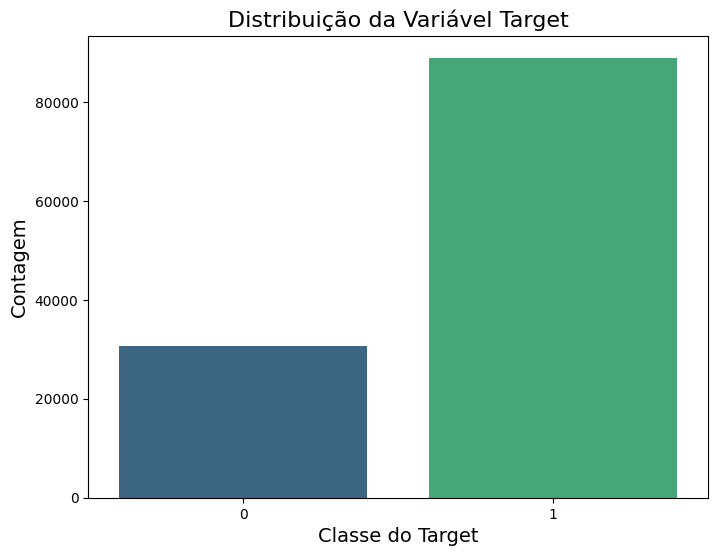

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Contar a frequência de cada valor na variável 'label'
class_counts = df['label'].value_counts()

# Exibir as contagens
print("Contagem das classes:")
print(class_counts)

# Calcular a proporção de cada classe
class_proportions = df['label'].value_counts(normalize=True)
print("\nProporção das classes:")
print(class_proportions)

# Plotar gráfico de barras para a distribuição das classes
plt.figure(figsize=(8, 6))
sns.countplot(x='label', data=df, palette='viridis')

# Adicionar título e rótulos
plt.title('Distribuição da Variável Dependente', fontsize=16)
plt.xlabel('Classe do Label', fontsize=14)
plt.ylabel('Contagem', fontsize=14)

# Exibir o gráfico
plt.show()

In [ ]:
# Separando os dados em treino e teste/validação
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['text'].tolist(),
    df['label'].tolist(),
    test_size=0.2, # 20% para validação
    random_state=42, # Para reprodutibilidade
    stratify=df['label']
)

In [ ]:
print(f"\nNúmero de amostras de treino: {len(train_texts)}")
print(f"Número de amostras de validação: {len(val_texts)}")


Número de amostras de treino: 95804
Número de amostras de validação: 23952


In [ ]:
# --- 2. Escolha do Modelo e Tokenizador ---
print("\n--- Etapa 2: Escolha do Modelo e Tokenizador ---")

# Vamos usar um modelo pré-treinado para português.
# Exemplos:
# a) 'neuralmind/bert-base-portuguese-cased'
# b) 'bert-base-multilingual-cased' (funciona bem para várias línguas, incluindo português)
# c) 'adalbertojunior/distilbert-portuguese-cased' (uma versão menor e mais rápida do BERT)

# Estamos selecionando o modelo abaixo, dado que não dispomos de GPU suficiente
# no Colab para o modelo "neuralmind/bert-base-portuguese-cased"
MODEL_NAME = 'adalbertojunior/distilbert-portuguese-cased'

try:
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
    # Seleciona num_labels=2 dado que dispomos de duas classes: Positivo e Negativo
    model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)
    print(f"Modelo e Tokenizador '{MODEL_NAME}' carregados com sucesso.")
except Exception as e:
    print(f"Erro ao carregar o modelo ou tokenizador: {e}")
    print("Verifique o nome do modelo ou sua conexão com a internet.")
    exit()


--- Etapa 2: Escolha do Modelo e Tokenizador ---


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/513 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/624 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/210k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/266M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at adalbertojunior/distilbert-portuguese-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Modelo e Tokenizador 'adalbertojunior/distilbert-portuguese-cased' carregados com sucesso.


In [ ]:
# --- 3. Tokenização dos Dados ---
print("\n--- Etapa 3: Tokenização dos Dados ---")

# Tokenizar os textos de treino e validação
# padding=True preenche as sequências para o tamanho da maior sequência no batch
# truncation=True trunca sequências maiores que o máximo suportado pelo modelo
# max_length pode ser ajustado, mas os modelos BERT geralmente usam 512
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=512)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=512)


--- Etapa 3: Tokenização dos Dados ---


In [ ]:
# --- 4. Criação do Dataset para o PyTorch ---
print("\n--- Etapa 4: Criação do Dataset para o PyTorch ---")

class SentimentDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        # Retorna um dicionário onde as chaves são os nomes dos inputs esperados pelo modelo
        # (ex: 'input_ids', 'attention_mask') e os valores são os tensores correspondentes.
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx]) # Adiciona os rótulos
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = SentimentDataset(train_encodings, train_labels)
val_dataset = SentimentDataset(val_encodings, val_labels)



--- Etapa 4: Criação do Dataset para o PyTorch ---


In [ ]:
# --- 5. Definição dos Argumentos de Treinamento e Treinador ---
print("\n--- Etapa 5: Definição dos Argumentos de Treinamento e Treinador ---")

# --- MONTAGEM DO GOOGLE DRIVE (Adicionar no início do seu notebook Colab)
from google.colab import drive
drive.mount('/content/drive')


--- Etapa 5: Definição dos Argumentos de Treinamento e Treinador ---
Mounted at /content/drive


In [ ]:
# --- 5. Definição dos Argumentos de Treinamento e Treinador ---
print("\n--- Etapa 5: Definição dos Argumentos de Treinamento e Treinador ---")

# Diretório raiz do Google Drive onde os dados serão salvos.
DRIVE_BASE_PATH = '/content/drive/MyDrive/ICMC/PLN/Transformers/'
output_dir_drive = DRIVE_BASE_PATH + 'results'
logging_dir_drive = DRIVE_BASE_PATH + 'logs'

# Certifique-se de que os diretórios existem (opcional, mas bom para evitar erros)
import os
os.makedirs(output_dir_drive, exist_ok=True)
os.makedirs(logging_dir_drive, exist_ok=True)

# Importar torch novamente para garantir que está disponível neste escopo
import torch

# Verificar se CUDA (GPU) está disponível e definir o dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")
model.to(device)

# Para visualizar o TensorBoard diretamente no notebook do Colab:
# %load_ext tensorboard
# E depois (ou durante) o treinamento:
# %tensorboard --logdir '/content/drive/MyDrive/ICMC/PLN/Transformers/logs' # Use o caminho do Drive aqui

training_args = TrainingArguments(
    output_dir=output_dir_drive,         # Diretório para salvar o modelo e logs NO GOOGLE DRIVE
    num_train_epochs=1,                  # Caso deseje melhorar a performance, alterar para um número maior de Epocs (3 ou 6)
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir=logging_dir_drive,       # Diretório para salvar logs do TensorBoard NO GOOGLE DRIVE
    logging_steps=150,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    report_to="tensorboard",
    fp16=True,
)


--- Etapa 5: Definição dos Argumentos de Treinamento e Treinador ---
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Usando dispositivo: cuda


In [ ]:
# Definir uma métrica de avaliação
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1) # Pega o índice da maior probabilidade (classe predita)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary') # 'binary' para 2 classes
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics, # Adiciona a função de métricas
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)] # Parar se não houver melhora por 3 épocas
)


In [ ]:
# --- 6. Treinamento do Modelo ---
print("\n--- Etapa 6: Treinamento do Modelo ---")

try:
    trainer.train()
    print("Treinamento concluído.")
except RuntimeError as e:
    if "out of memory" in str(e).lower():
        print("\nErro: CUDA out of memory. Tente reduzir 'per_device_train_batch_size'.")
    else:
        print(f"\nErro durante o treinamento: {e}")
    print("Continuando com o modelo pré-treinado (sem fine-tuning) para demonstração da predição.")


--- Etapa 6: Treinamento do Modelo ---


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.199500,0.179979,0.946643,0.963982,0.967198,0.960787


Treinamento concluído.


In [ ]:
# --- 7. Avaliação do Modelo (Opcional aqui, pois já é feito durante o treino) ---
print("\n--- Etapa 7: Avaliação do Modelo ---")

# Se treinou, você pode chamar explicitamente a avaliação:
results = trainer.evaluate()
print("Resultados da avaliação:")
print(results)


--- Etapa 7: Avaliação do Modelo ---


Resultados da avaliação:
{'eval_loss': 0.17997916042804718, 'eval_accuracy': 0.9466432865731463, 'eval_f1': 0.9639817372188716, 'eval_precision': 0.9671982807374732, 'eval_recall': 0.9607865168539326, 'eval_runtime': 95.0354, 'eval_samples_per_second': 252.032, 'eval_steps_per_second': 15.752, 'epoch': 1.0}


In [ ]:
# --- 8. Função de Predição com Probabilidades ---
print("\n--- Etapa 8: Função de Predição com Probabilidades ---")

def predict_sentiment_probability(text, model_to_use, tokenizer_to_use, device_to_use):

    # Mover o modelo para o dispositivo correto, caso ainda não esteja
    model_to_use.to(device_to_use)
    model_to_use.eval() # Colocar o modelo em modo de avaliação

    # Tokenizar o texto de entrada
    inputs = tokenizer_to_use(
        text,
        return_tensors="pt", # Retornar tensores PyTorch
        truncation=True,
        padding=True,
        max_length=512
    )

    # Mover os inputs para o mesmo dispositivo do modelo
    inputs = {key: val.to(device_to_use) for key, val in inputs.items()}

    # Fazer a predição (sem calcular gradientes)
    with torch.no_grad():
        outputs = model_to_use(**inputs)

    # Os 'outputs' contêm os 'logits' (valores brutos antes da função de ativação final)
    logits = outputs.logits

    # Aplicar a função softmax para converter logits em probabilidades
    # A softmax garante que as probabilidades somem 1 entre as classes.
    probabilities = softmax(logits.cpu().numpy(), axis=1)[0] # Pegamos o primeiro (e único) item do batch

    # 'probabilities' será um array como [prob_negativa, prob_positiva]
    # pois num_labels=2 e assumimos que o label 0 é Negativo e 1 é Positivo.
    # Verifique a ordem dos rótulos se você treinou o modelo de forma diferente.
    # Geralmente, o índice 0 corresponde à classe 0 e o índice 1 à classe 1.

    prob_negativa = probabilities[0] # Probabilidade da classe 0 (Negativo)
    prob_positiva = probabilities[1] # Probabilidade da classe 1 (Positivo)

    return {
        "texto": text,
        "probabilidade_negativo": prob_negativa * 100, # Em percentual
        "probabilidade_positivo": prob_positiva * 100, # Em percentual
        "sentimento_predito": "Positivo" if prob_positiva > prob_negativa else "Negativo",
        "score_predito_positivo": prob_positiva
    }

In [ ]:
# --- 9. Exemplo de Uso da Função de Predição ---
print("\n--- Etapa 9: Exemplo de Uso da Função de Predição ---")

# Textos de exemplo para testar a predição
textos_para_teste = [
    "Suporte muito bom. Veio com varias opções de fixação e aguenta TV’s grandes. Valeu super a pena. Fácil instalação, seguindo vídeo explicativo.",
    "Muito ruim trava usei 5 vezes e agora não liga mais.",
    "É um filme ok, nada de especial mas dá para assistir.",
    "Serviço péssimo, nunca mais volto neste lugar."
]

for texto_exemplo in textos_para_teste:
    resultado_predicao = predict_sentiment_probability(texto_exemplo, model, tokenizer, device)
    print(f"\nTexto: {resultado_predicao['texto']}")
    print(f"  Probabilidade de ser Negativo: {resultado_predicao['probabilidade_negativo']:.2f}%")
    print(f"  Probabilidade de ser Positivo: {resultado_predicao['probabilidade_positivo']:.2f}%")
    print(f"  Sentimento Predito: {resultado_predicao['sentimento_predito']}")


--- Etapa 8: Função de Predição com Probabilidades ---

--- Etapa 9: Exemplo de Uso da Função de Predição ---

Texto: Suporte muito bom. Veio com varias opções de fixação e aguenta TV’s grandes. Valeu super a pena. Fácil instalação, seguindo vídeo explicativo.
  Probabilidade de ser Negativo: 0.40%
  Probabilidade de ser Positivo: 99.60%
  Sentimento Predito: Positivo

Texto: Muito ruim trava usei 5 vezes e agora não liga mais.
  Probabilidade de ser Negativo: 98.57%
  Probabilidade de ser Positivo: 1.43%
  Sentimento Predito: Negativo

Texto: É um filme ok, nada de especial mas dá para assistir.
  Probabilidade de ser Negativo: 1.12%
  Probabilidade de ser Positivo: 98.88%
  Sentimento Predito: Positivo

Texto: Serviço péssimo, nunca mais volto neste lugar.
  Probabilidade de ser Negativo: 98.09%
  Probabilidade de ser Positivo: 1.91%
  Sentimento Predito: Negativo


In [ ]:
# --- 10. Salvando o Modelo Fine-Tuned
print("\n--- Etapa 10: Salvando o Modelo Fine-Tuned ---")

# Se você treinou o modelo e quer salvá-lo para uso futuro:
model_save_path = DRIVE_BASE_PATH + 'modelo'
if 'trainer' in locals() and trainer.state.best_model_checkpoint:
    print(f"Salvando o melhor modelo de '{trainer.state.best_model_checkpoint}' em '{model_save_path}'...")

# O Trainer já salva o melhor modelo em output_dir/checkpoint-XXXX
# Você pode copiar/renomear esse checkpoint ou salvar o modelo explicitamente
    model.save_pretrained(model_save_path)
    tokenizer.save_pretrained(model_save_path)
    print(f"Modelo e tokenizador salvos em '{model_save_path}'.")
else:
    print("Nenhum modelo treinado para salvar ou o treinamento não foi executado.")

# Para carregar um modelo salvo localmente:
# model_loaded = AutoModelForSequenceClassification.from_pretrained(model_save_path)
# tokenizer_loaded = AutoTokenizer.from_pretrained(model_save_path)
# print(f"\nModelo carregado de '{model_save_path}' para uso.")

print("\n--- Fim do Script ---")


--- Etapa 10: Salvando o Modelo Fine-Tuned ---
Salvando o melhor modelo de '/content/drive/MyDrive/ICMC/PLN/Transformers/results/checkpoint-11976' em '/content/drive/MyDrive/ICMC/PLN/Transformers/modelo'...
Modelo e tokenizador salvos em '/content/drive/MyDrive/ICMC/PLN/Transformers/modelo'.

--- Fim do Script ---


<ipython-input-30-715d607f85a0>:49: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing', color='grey')


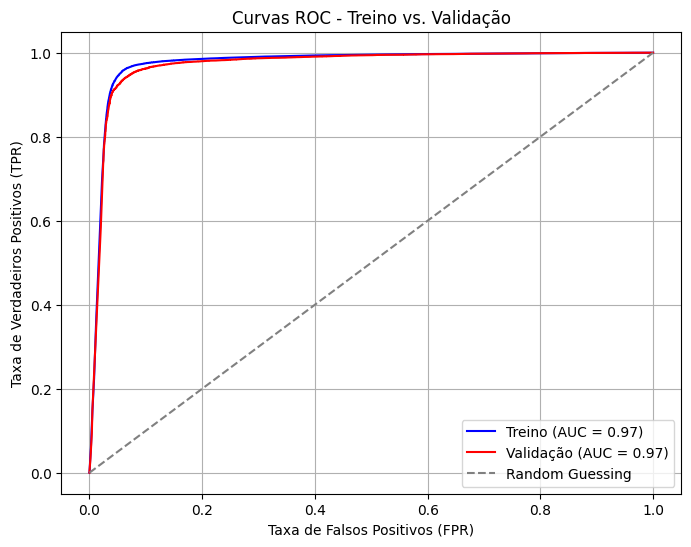

In [ ]:
import torch
import numpy as np
from sklearn.metrics import roc_curve, auc
from scipy.special import softmax
import matplotlib.pyplot as plt

def calculate_probabilities(dataset, model, tokenizer, device):

    true_labels = []
    predicted_probs = []

    for item in dataset:
        # Obter texto original e rótulo verdadeiro
        true_label = item['labels'].item()
        true_labels.append(true_label)

        # Preparar entrada para o modelo
        inputs = {key: item[key].unsqueeze(0).to(device) for key in ['input_ids', 'attention_mask']}

        # Fazer a predição
        with torch.no_grad():
            outputs = model(**inputs)

        # Aplicar softmax para obter probabilidades
        logits = outputs.logits
        probabilities = softmax(logits.cpu().numpy(), axis=1)[0]
        predicted_probs.append(probabilities[1])  # Probabilidade da classe positiva

    return true_labels, predicted_probs

def plot_roc_curves(train_true, train_probs, val_true, val_probs):

    # Gerar curvas ROC
    train_fpr, train_tpr, _ = roc_curve(train_true, train_probs)
    val_fpr, val_tpr, _ = roc_curve(val_true, val_probs)

    # Calcular AUC
    train_auc = auc(train_fpr, train_tpr)
    val_auc = auc(val_fpr, val_tpr)

    # Plotar curvas ROC
    plt.figure(figsize=(8, 6))
    plt.plot(train_fpr, train_tpr, label=f'Treino (AUC = {train_auc:.2f})', color='blue')
    plt.plot(val_fpr, val_tpr, label=f'Validação (AUC = {val_auc:.2f})', color='red')
    plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing', color='grey')
    plt.xlabel('Taxa de Falsos Positivos (FPR)')
    plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
    plt.title('Curvas ROC - Treino vs. Validação')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

# Configurações do dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Supondo que train_dataset e val_dataset já estejam carregados
def predict_and_evaluate(model, tokenizer, train_dataset, val_dataset):

    # Calcular probabilidades para treino
    train_true, train_probs = calculate_probabilities(train_dataset, model, tokenizer, device)

    # Calcular probabilidades para validação
    val_true, val_probs = calculate_probabilities(val_dataset, model, tokenizer, device)

    # Plotar as curvas ROC
    plot_roc_curves(train_true, train_probs, val_true, val_probs)

# Exemplo de chamada (substitua pelas instâncias reais):
predict_and_evaluate(model, tokenizer, train_dataset, val_dataset)

In [ ]:
# Para carregar um modelo salvo localmente:
model_save_path = DRIVE_BASE_PATH + 'modelo'
model_loaded = AutoModelForSequenceClassification.from_pretrained(model_save_path)
tokenizer_loaded = AutoTokenizer.from_pretrained(model_save_path)
print(f"\nModelo carregado de '{model_save_path}' para uso.")


Modelo carregado de '/content/drive/MyDrive/ICMC/PLN/Transformers/modelo' para uso.


In [ ]:
# --- 9. Exemplo de Uso da Função de Predição ---
print("\n--- Etapa 9: Exemplo de Uso da Função de Predição ---")

# Textos de exemplo para testar a predição
textos_para_teste = [
    "Estou muito satisfeito com o laptop que eu comprei!",
    "Péssimo o desempenho desta TV.",
    "O refrigerador não funciona.",
    "Comprar aqui nunca mais!!!",
    "Comprar aqui nuncaaaaaaa mais!!!",
    "Comprar aqui nuncaaaaaaaaaaa mais!!!",
    "Comprar aqui nuncaaaaaaaaaaaaaaaaaa mais!!!!!!!!!",
    "Gostei do desempenho deste computador. Recomendo a compra"
]

for texto_exemplo in textos_para_teste:
    resultado_predicao = predict_sentiment_probability(texto_exemplo, model, tokenizer, device)
    print(f"\nTexto: {resultado_predicao['texto']}")
    print(f"  Probabilidade de ser Negativo: {resultado_predicao['probabilidade_negativo']:.2f}%")
    print(f"  Probabilidade de ser Positivo: {resultado_predicao['probabilidade_positivo']:.2f}%")
    print(f"  Sentimento Predito: {resultado_predicao['sentimento_predito']}")


--- Etapa 9: Exemplo de Uso da Função de Predição ---

Texto: Estou muito satisfeito com o laptop que eu comprei!
  Probabilidade de ser Negativo: 0.40%
  Probabilidade de ser Positivo: 99.60%
  Sentimento Predito: Positivo

Texto: Péssimo o desempenho desta TV.
  Probabilidade de ser Negativo: 94.14%
  Probabilidade de ser Positivo: 5.86%
  Sentimento Predito: Negativo

Texto: O refrigerador não funciona.
  Probabilidade de ser Negativo: 97.09%
  Probabilidade de ser Positivo: 2.91%
  Sentimento Predito: Negativo

Texto: Comprar aqui nunca mais!!!
  Probabilidade de ser Negativo: 88.49%
  Probabilidade de ser Positivo: 11.51%
  Sentimento Predito: Negativo

Texto: Comprar aqui nuncaaaaaaa mais!!!
  Probabilidade de ser Negativo: 89.36%
  Probabilidade de ser Positivo: 10.64%
  Sentimento Predito: Negativo

Texto: Comprar aqui nuncaaaaaaaaaaa mais!!!
  Probabilidade de ser Negativo: 90.52%
  Probabilidade de ser Positivo: 9.48%
  Sentimento Predito: Negativo

Texto: Comprar aqui nunca